# QC for sample Vehicle (ATAC only)

## Set up correct conda environment

In [1]:
.libPaths()

[1] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [2]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

## Load packages

In [3]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk'

In [4]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/users/xjluo/miniconda3/envs/jupyter_env/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggExtra_0.10.1                     ggpointdensity_0.1.0              
 [3] BSgenome.Mmusculus.UCSC.mm10_1.4.3 BSgenome_1.66.3                   
 [5] rtracklayer_1.58.0                 Biostrings_2.66.0                 
 [7] XVector_0.38.0                     EnsDb.Mmuscu

# Sample

In [5]:
sample <- 'V1'

# Thresholds

In [6]:
# Di Bella & Habibi et al. 2021
# https://www.nature.com/articles/s41586-021-03670-5
# peak_region_fragments >3,000 & peak_region_fragments <100,000; pct_reads_in_peaks >40; blacklist_ratio <0.025 ; nucleosome_signal <4; TSS.enrichment >2

min_pct_frags_in_peaks <- 40
min_peak_region_fragments <- 6000
max_peak_region_fragments <- 100000
max_blacklist_ratio <- 0.025
max_nucleosome_signal <- 4
min_tss_enrich <- 2


# Paths

In [7]:
# Output directory for this notebook (objects will be saved here)
outdir <- '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS'

In [8]:
# MACS peak-calling software
macs_path <- '/home/groups/tttt/xjluo/miniconda3/envs/macs3_env/bin/macs3'

In [9]:
# Data
output_dir_10x <- '/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/'

counts_file_original <- paste0(output_dir_10x, sample, '_outs', '/', 'filtered_peak_bc_matrix.h5')
frag_file <- paste0(output_dir_10x, sample, '_outs', '/', 'fragments.tsv.gz')
metrics_file <- paste0(output_dir_10x, sample, '_outs', '/', sample, '_singlecell.csv')


In [10]:
counts_file_original
frag_file
metrics_file

[1] "/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/V1_outs/filtered_peak_bc_matrix.h5"

[1] "/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/V1_outs/fragments.tsv.gz"

[1] "/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/V1_outs/V1_singlecell.csv"

# Load Data

In [11]:
# ATAC peak-barcode matrix
# contains filtered barcodes by Cell Ranger

atac_counts <- Read10X_h5(counts_file_original)
class(atac_counts)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [12]:
dim(atac_counts)

[1] 102595    629

In [13]:
# get gene annotations for mm10
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotation) <- "UCSC"

# Load Metrics

In [14]:
metrics <- read.csv(
  file = metrics_file,
  header = TRUE,
  row.names = 1
)


In [15]:
head(metrics)
dim(metrics)

,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,passed_filters,is__cell_barcode,excluded_reason,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NO_BARCODE,1910746,75471,193,195604,106805,971,212,1531490,0,0,0,0,0,0,0,0,0,0
AAACGAAAGAAAGGGT-1,70,2,0,1,6,0,0,61,0,3,16,0,0,0,16,0,31,62
AAACGAAAGAAATACC-1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACGAAAGAACAGGA-1,12,2,0,1,4,0,0,5,0,0,0,0,0,0,0,0,1,2
AAACGAAAGAACGTTA-1,6,0,0,0,1,0,0,5,0,0,2,0,0,0,2,0,1,2
AAACGAAAGAACTAAC-1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 168857     18

In [16]:
metrics_filt_cellranger_bc <- metrics[metrics$is__cell_barcode==1,]
head(metrics_filt_cellranger_bc)
dim(metrics_filt_cellranger_bc)

,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,passed_filters,is__cell_barcode,excluded_reason,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACGAAAGCGTCAAG-1,98537,31419,3,1122,5150,16,14,60813,1,0,12544,0,0,0,12544,0,22599,43247
AAACGAACACAATAAG-1,78165,35214,4,935,2855,151,4,39002,1,0,10022,0,0,0,10022,0,20396,39551
AAACGAACATAGCCAT-1,75461,32127,2,966,2818,2,5,39541,1,0,11342,0,0,0,11342,0,21781,42209
AAACTCGAGAGCGGTT-1,87435,32376,1,948,3599,27,2,50482,1,0,12283,0,0,0,12283,0,22555,43397
AAACTCGAGTTCCCGG-1,66401,25900,1,808,2700,0,3,36989,1,0,9807,0,0,0,9807,0,18931,36671
AAACTCGGTTATCGAC-1,77825,34770,1,983,2997,42,9,39023,1,0,10549,0,0,0,10549,0,21078,41022


[1] 629  18

In [17]:
# sanity check to make sure metadata csv "is_cell" barcodes match up with columns (i.e. cell barcodes) of filtered bc matrix
setequal(rownames(metrics_filt_cellranger_bc),
         colnames(atac_counts))

[1] TRUE

In [18]:
# verify uniqueness
length(rownames(metrics_filt_cellranger_bc)) == length(unique(rownames(metrics_filt_cellranger_bc)))

[1] TRUE

# Create ATAC object

In [19]:
# create a Seurat object containing the ATAC data (no AMULET doublet removal yet)
obj <- CreateSeuratObject(
    counts = atac_counts,
    assay = "ATAC",
    meta.data = metrics_filt_cellranger_bc
)

obj

An object of class Seurat 
102595 features across 629 samples within 1 assay 
Active assay: ATAC (102595 features, 0 variable features)

In [20]:
# create ATAC assay and add it to the object
# NOTE: using CellRanger peaks just to check sample quality/UMAP, not used for further integration with scRNA-seq or ATAC doublet removal
obj[["ATAC"]] <- CreateChromatinAssay(
    counts = atac_counts,    
    sep = c(":", "-"),
    genome = "mm10",
    fragments = frag_file,
    annotation = annotation
)

obj

Computing hash



An object of class Seurat 
102595 features across 629 samples within 1 assay 
Active assay: ATAC (102595 features, 0 variable features)

## Inspect parts of object

In [21]:
head(rownames(GetAssayData(obj, assay = 'ATAC', slot = 'data')))
head(colnames(GetAssayData(obj, assay = 'ATAC', slot = 'data')))
dim(GetAssayData(obj, assay = 'ATAC', slot = 'data'))

[1] "chr1-3113330-3114248" "chr1-3119920-3120715" "chr1-3121307-3122076"
[4] "chr1-3164535-3165385" "chr1-3292251-3293310" "chr1-3297316-3298204"

[1] "AAACGAAAGCGTCAAG-1" "AAACGAACACAATAAG-1" "AAACGAACATAGCCAT-1"
[4] "AAACTCGAGAGCGGTT-1" "AAACTCGAGTTCCCGG-1" "AAACTCGGTTATCGAC-1"

[1] 102595    629

In [22]:
head(obj@meta.data)
dim(obj@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,passed_filters,is__cell_barcode,excluded_reason,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACGAAAGCGTCAAG-1,SeuratProject,43247,16981,98537,31419,3,1122,5150,16,14,60813,1,0,12544,0,0,0,12544,0,22599,43247
AAACGAACACAATAAG-1,SeuratProject,39551,15490,78165,35214,4,935,2855,151,4,39002,1,0,10022,0,0,0,10022,0,20396,39551
AAACGAACATAGCCAT-1,SeuratProject,42209,15998,75461,32127,2,966,2818,2,5,39541,1,0,11342,0,0,0,11342,0,21781,42209
AAACTCGAGAGCGGTT-1,SeuratProject,43397,16869,87435,32376,1,948,3599,27,2,50482,1,0,12283,0,0,0,12283,0,22555,43397
AAACTCGAGTTCCCGG-1,SeuratProject,36671,14349,66401,25900,1,808,2700,0,3,36989,1,0,9807,0,0,0,9807,0,18931,36671
AAACTCGGTTATCGAC-1,SeuratProject,41022,15677,77825,34770,1,983,2997,42,9,39023,1,0,10549,0,0,0,10549,0,21078,41022


[1] 629  21

# QC

In [23]:
DefaultAssay(obj) <- "ATAC"

obj <- NucleosomeSignal(obj)
obj <- TSSEnrichment(obj, fast=FALSE)

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



In [24]:
# metadata columns documentation: https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/singlecell

# fractions from https://stuartlab.org/signac/articles/mouse_brain_vignette

# CAVEAT: fragments in 'peak_region_fragments' is *not necessarily* a subset of 'passed_filters'
# but it's likely the vast majority of the former*are* a subset of the latter

obj$pct_frags_in_peaks <- (obj$peak_region_fragments / obj$passed_filters) * 100
obj$blacklist_ratio <- obj$blacklist_region_fragments / obj$peak_region_fragments

## Visualize QC

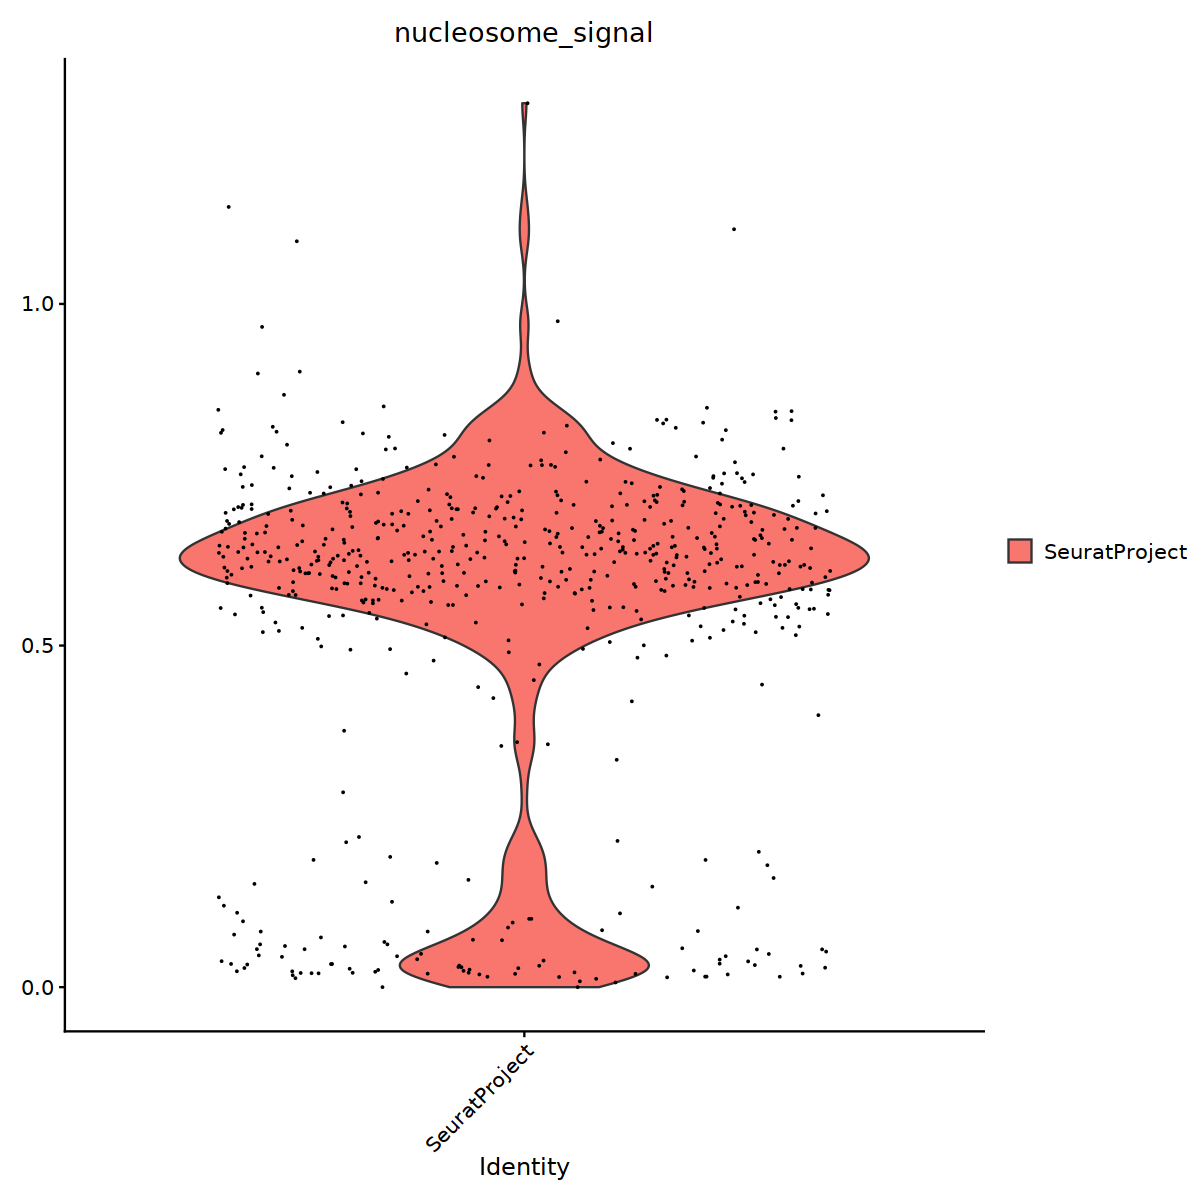

In [25]:
options(repr.plot.width=10, repr.plot.height=10)

VlnPlot(
    object = obj,
    features = "nucleosome_signal"
)

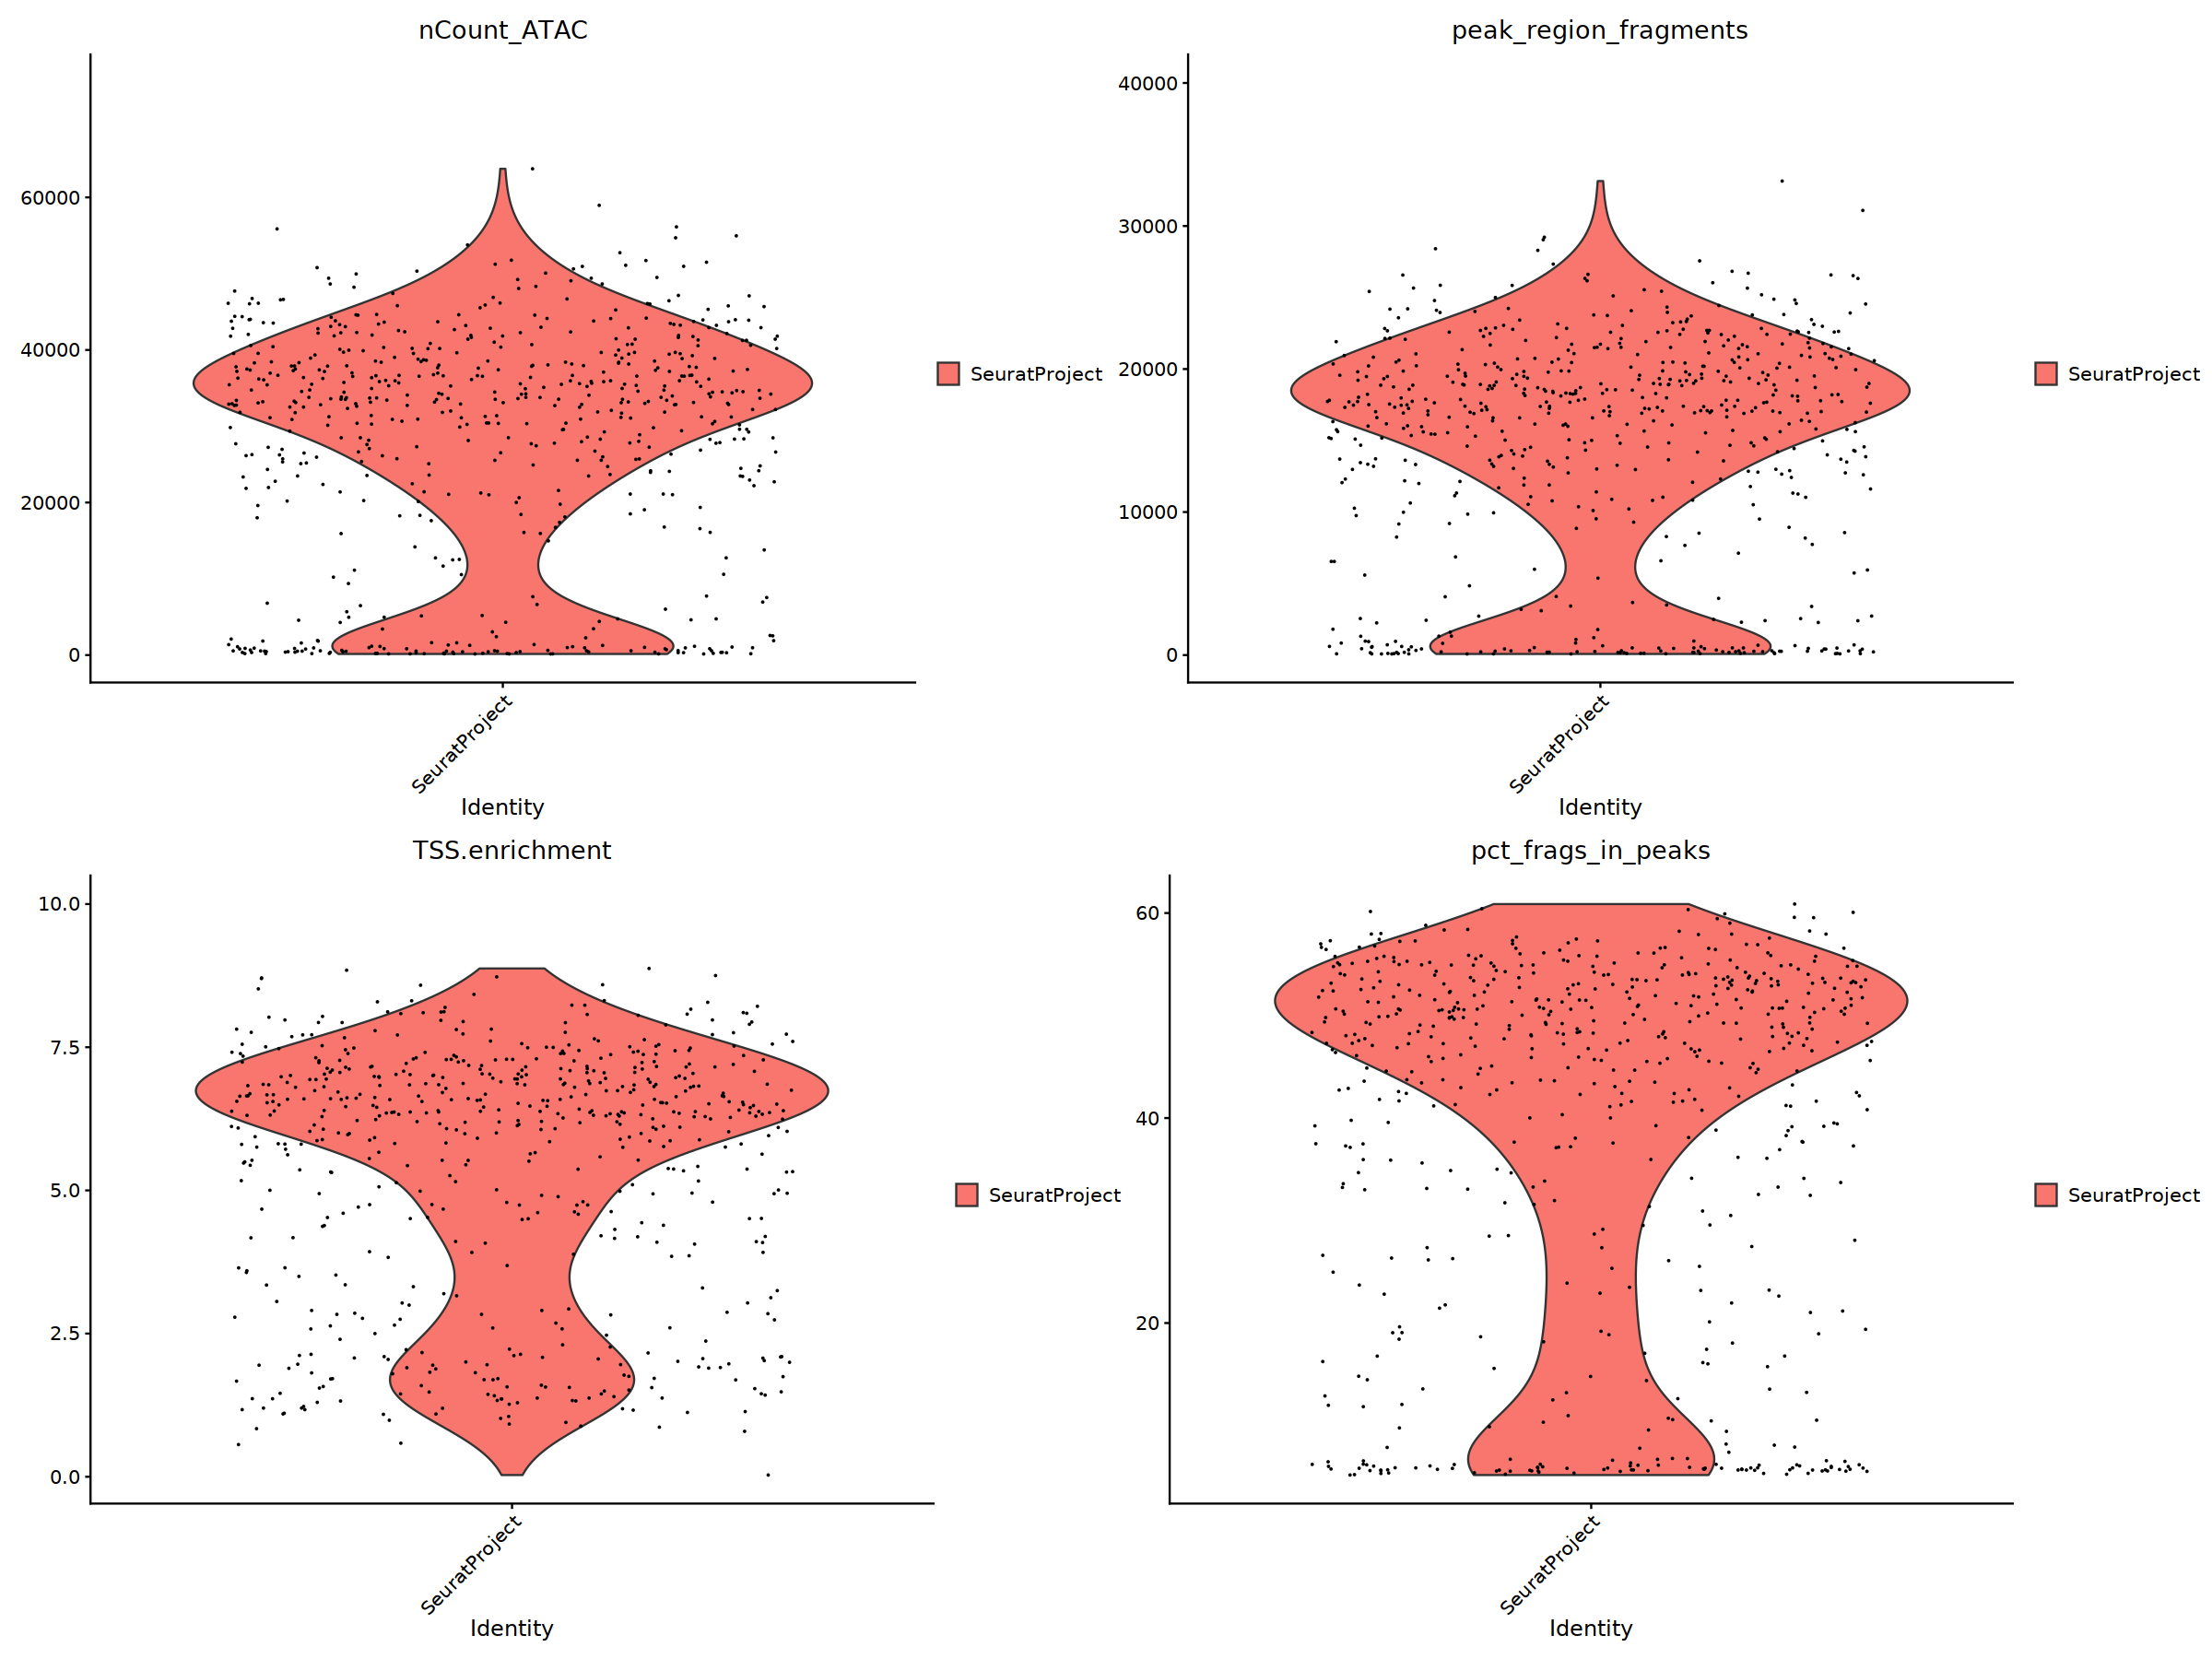

In [26]:
options(repr.plot.width=20, repr.plot.height=15)

atac1 <- VlnPlot(
    object = obj,
    features = "nCount_ATAC",
    y.max = 75000,
)

atac2 <- VlnPlot(
    object = obj,
    features = "peak_region_fragments",
    y.max = 40000,
)


atac3 <- VlnPlot(
    object = obj,
    features = "TSS.enrichment",
    y.max = 10,
)

atac4 <- VlnPlot(
    object = obj,
    features = "pct_frags_in_peaks"
)

(atac1 | atac2) /
(atac3 | atac4)
     

## ATAC: TSS Enrichment vs. Counts

In [27]:
min_ncount_atac <- 500
max_ncount_atac <- 30000

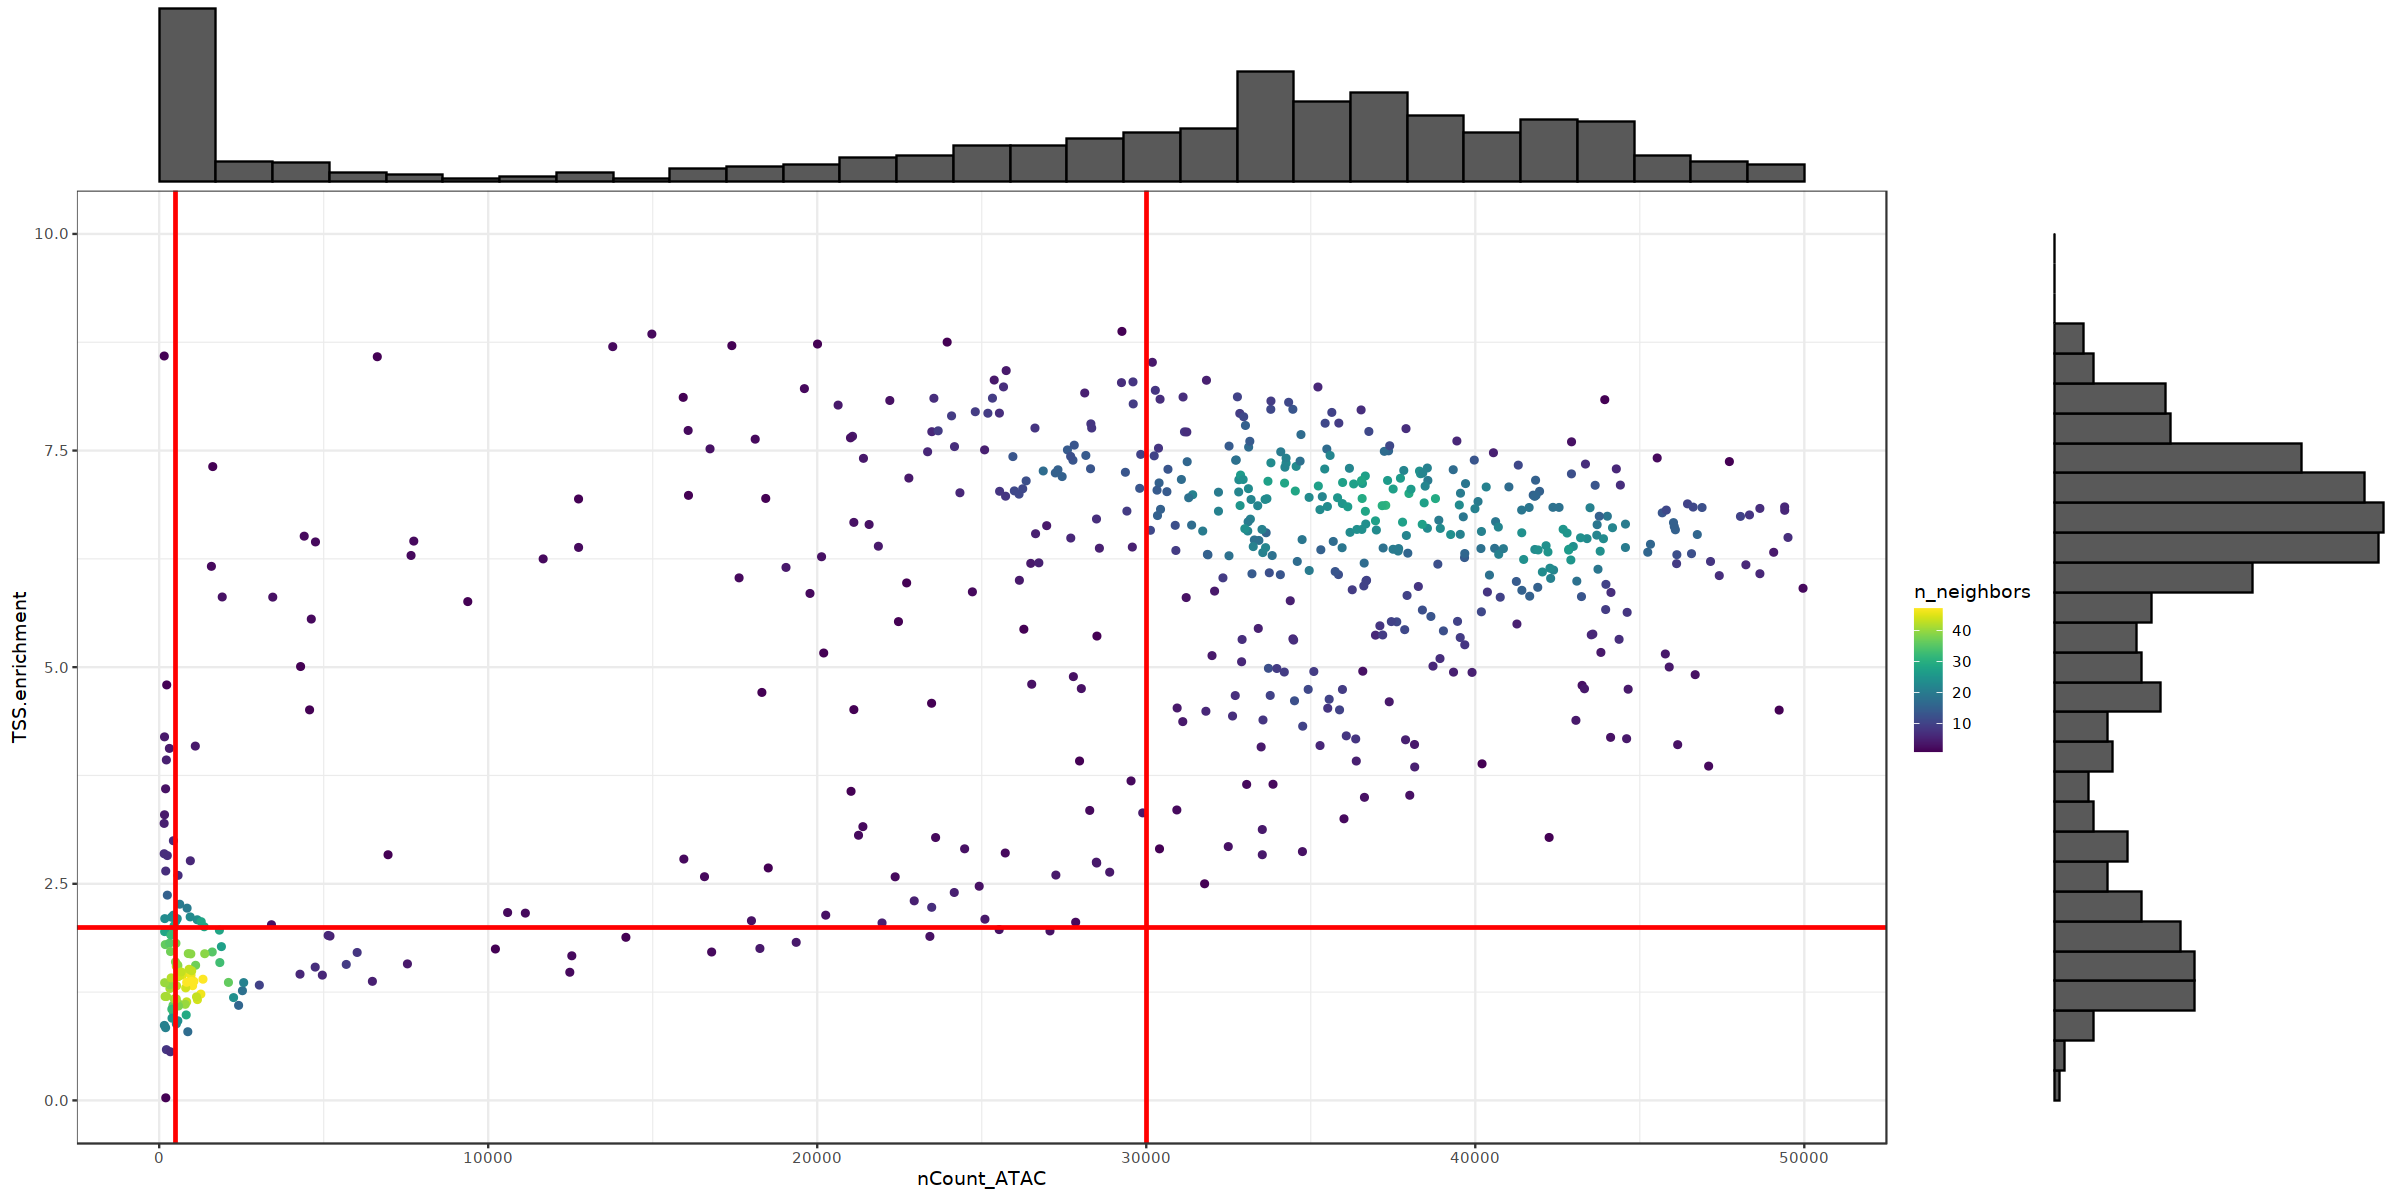

In [28]:
options(repr.plot.width=20, repr.plot.height=10)

scatter5 <- ggplot(obj@meta.data, aes(x=nCount_ATAC, y=TSS.enrichment)) +
                geom_pointdensity() +
                scale_color_viridis() +
                theme_bw() +
                geom_vline(xintercept=min_ncount_atac, size=1, color='red') +
                geom_hline(yintercept=min_tss_enrich, size=1, color='red') +
                geom_vline(xintercept=max_ncount_atac, size=1, color='red') +
                xlim(0, max_ncount_atac + 20000) +
                ylim(0, 10)

scatter6 <- ggplot(obj@meta.data, aes(x=nCount_ATAC, y=TSS.enrichment)) +
                geom_pointdensity() +
                scale_color_viridis() +
                theme_bw() +
                geom_vline(xintercept=min_ncount_atac, size=1, color='red') +
                geom_hline(yintercept=min_tss_enrich, size=1, color='red') +
                geom_vline(xintercept=max_ncount_atac, size=1, color='red') +
                xlim(0, min_ncount_atac + 10000) +
                ylim(0, 10)

scatter5_marg <- ggMarginal(scatter5, type="histogram")
scatter6_marg <- ggMarginal(scatter6, type="histogram")

scatter5_marg
     

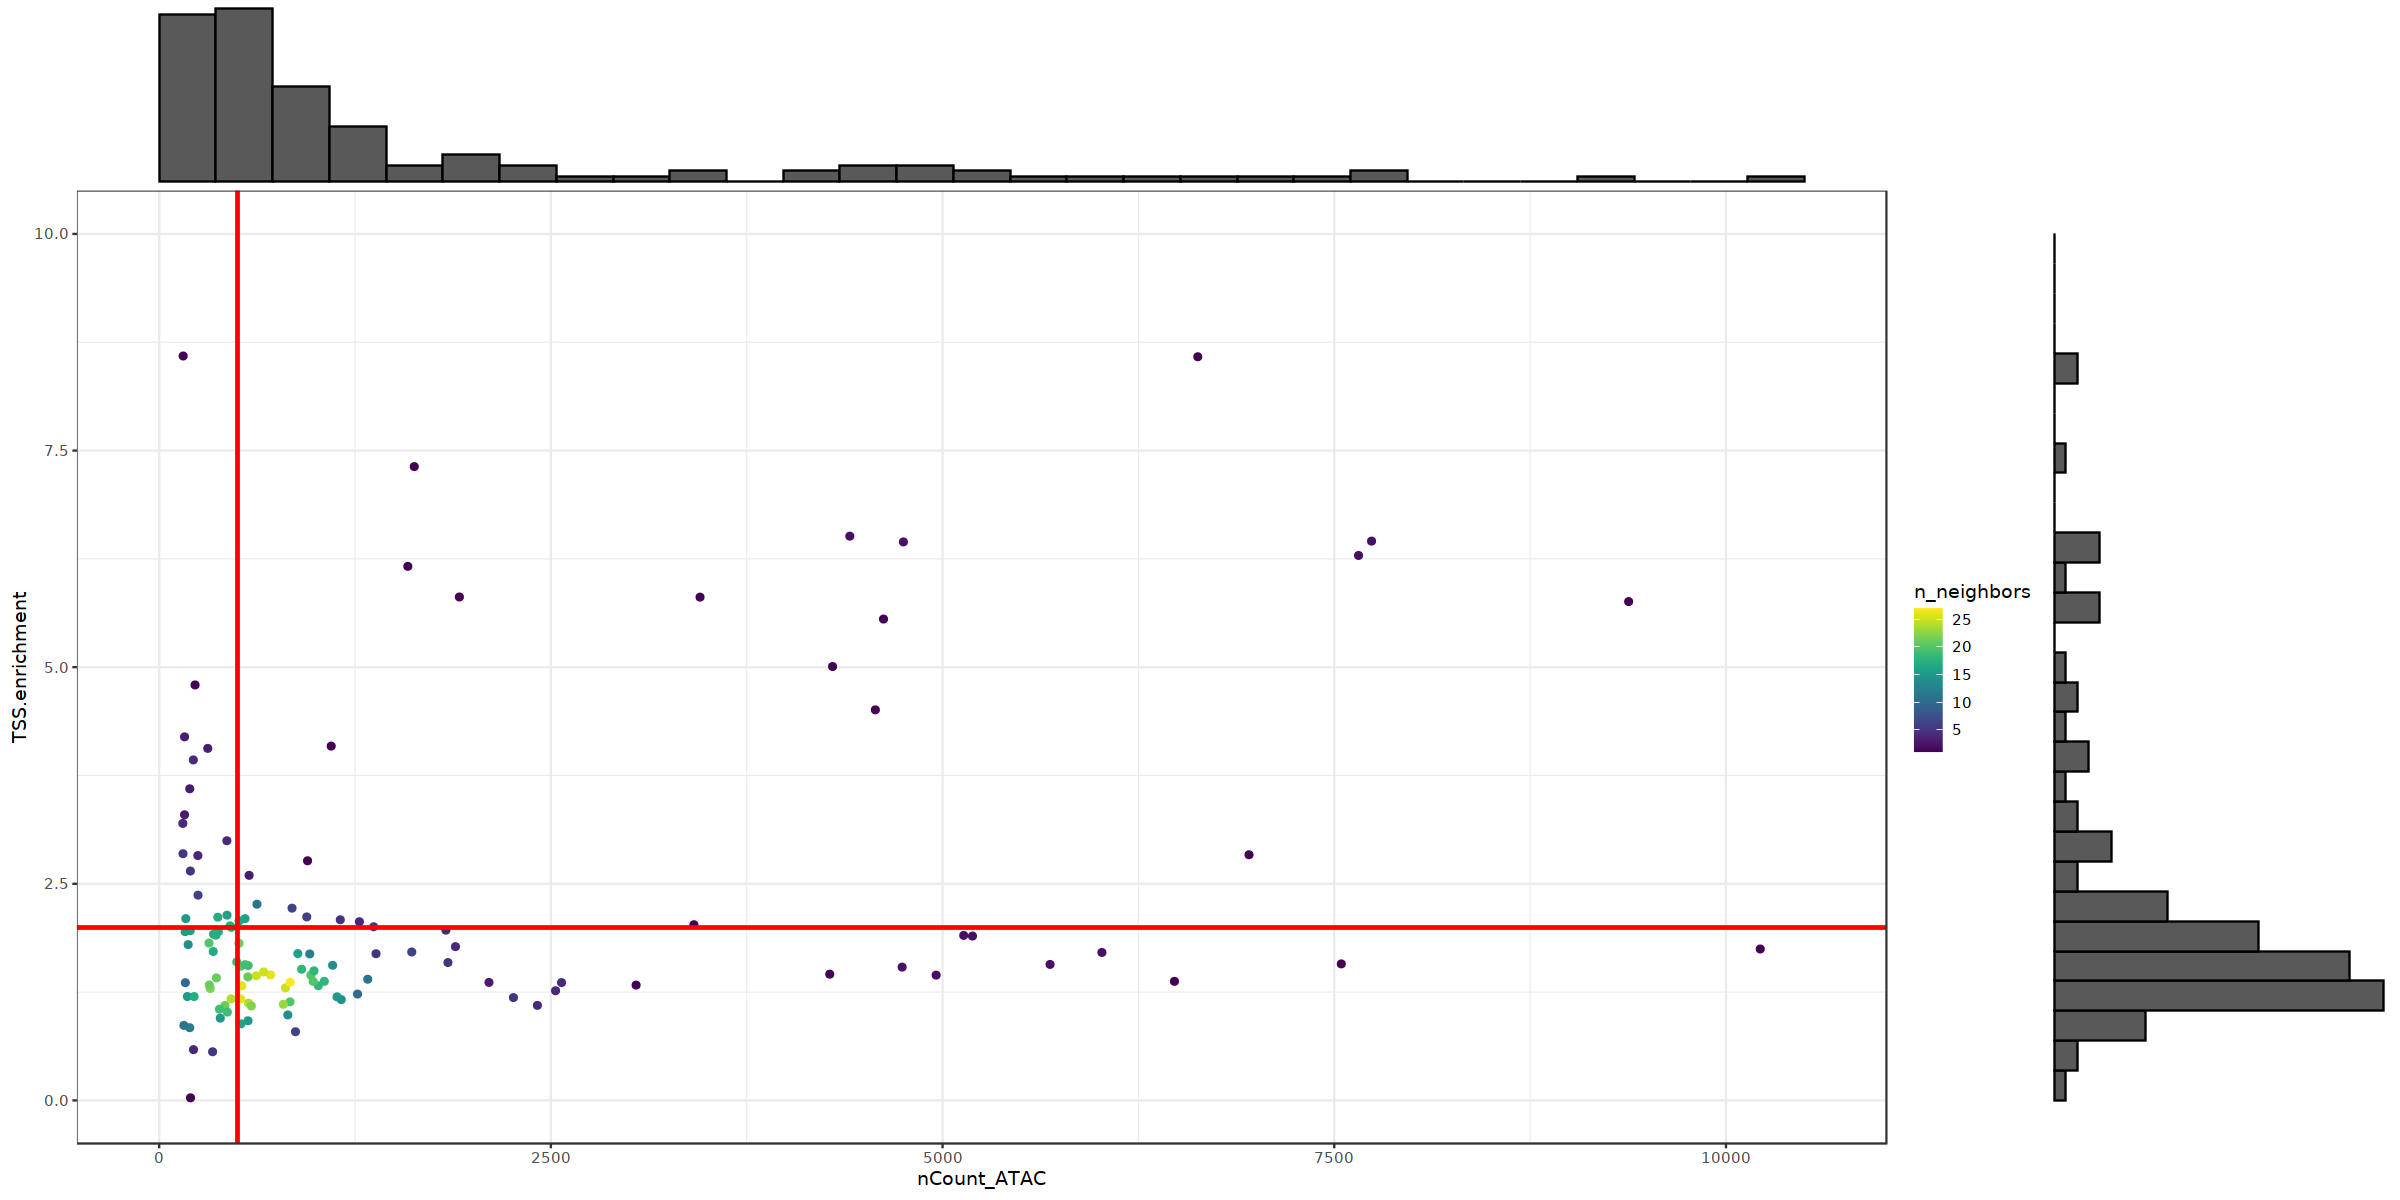

In [29]:
scatter6_marg

## ATAC: Fragment Length Distribution and TSS Enrichment


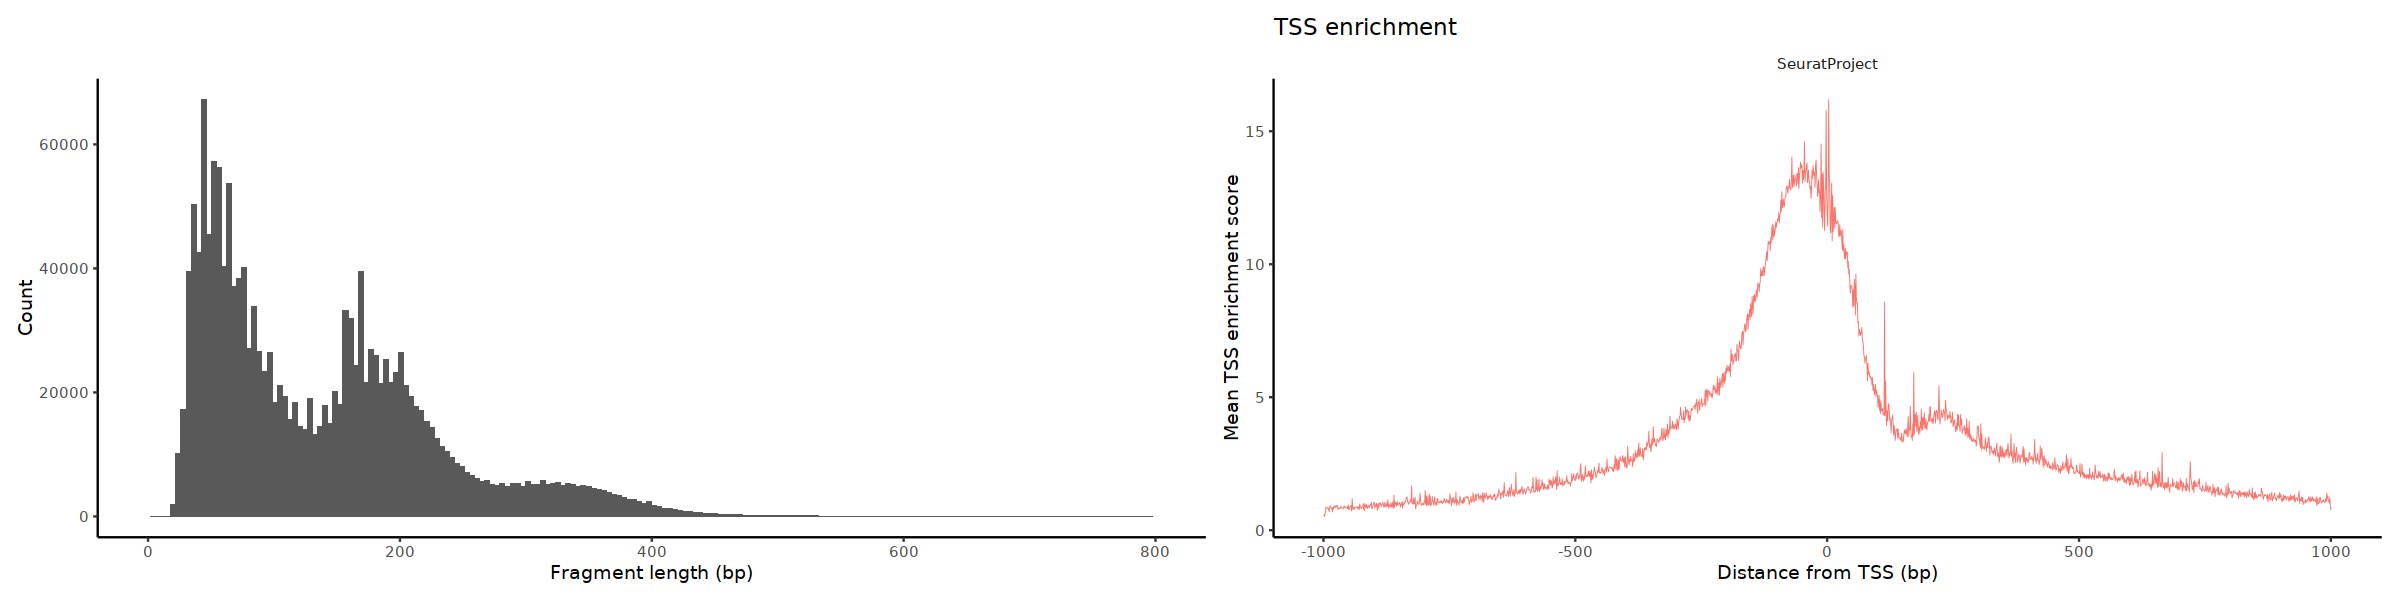

In [30]:
options(repr.plot.width=20, repr.plot.height=5)

plot1 <- FragmentHistogram(object=obj, 
                           region = "chr1-1-195471971",    # http://hgdownload.cse.ucsc.edu/goldenpath/mm10/bigZips/mm10.chrom.sizes
                           assay='ATAC')

plot2 <- TSSPlot(object=obj, assay='ATAC')

(plot1 | plot2)
     

## Save original object

In [31]:
saveRDS(obj, file = paste0(outdir, "/original_objects/", sample, ".original.rds"))
obj

An object of class Seurat 
102595 features across 629 samples within 1 assay 
Active assay: ATAC (102595 features, 0 variable features)

# Filter cells

In [32]:
# filter out low quality cells
filtered_pre_macs <- subset(
  x = obj,
  subset = pct_frags_in_peaks > min_pct_frags_in_peaks &
           TSS.enrichment > min_tss_enrich &
           peak_region_fragments > min_peak_region_fragments &
           peak_region_fragments < max_peak_region_fragments &
           blacklist_ratio < max_blacklist_ratio &
           nucleosome_signal < max_nucleosome_signal
)

filtered_pre_macs

An object of class Seurat 
102595 features across 390 samples within 1 assay 
Active assay: ATAC (102595 features, 0 variable features)

# MACS3 peak calling

In [33]:
if (!dir.exists(paste0(outdir, "/macs3_inputs/"))) {
    dir.create(paste0(outdir, "/macs3_inputs/"))
}

In [34]:
if (!dir.exists(paste0(outdir, "/macs3_outputs/"))) {
    dir.create(paste0(outdir, "/macs3_outputs/"))
}

## Subset fragments file for passed-QC barcodes

In [35]:
frag_file

[1] "/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/V1_outs/fragments.tsv.gz"

In [36]:
subsetted_frag_file <- paste0(outdir, "/macs3_inputs/", sample, '_filt_fragments.tsv.gz')
subsetted_frag_file

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs/V1_filt_fragments.tsv.gz"

In [37]:
# sanity check
setequal(colnames(filtered_pre_macs), Cells(filtered_pre_macs))

head(colnames(filtered_pre_macs))
length(colnames(filtered_pre_macs))

[1] TRUE

[1] "AAACGAACACAATAAG-1" "AAACGAACATAGCCAT-1" "AAACTCGAGAGCGGTT-1"
[4] "AAACTCGAGTTCCCGG-1" "AAACTCGGTTATCGAC-1" "AAACTGCCAGATAAGT-1"

[1] 390

In [38]:
FilterCells(
  fragments = frag_file,
  cells = colnames(filtered_pre_macs),
  outfile = subsetted_frag_file
)



Compressing filtered file

Indexing fragment file



## Generate Tn5 cut sites 'reads' file


In [39]:
macs_outdir <- paste0(outdir, "/macs3_inputs/")

macs_outdir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs/"

In [40]:
# decompress fragments file

subsetted_frag_file_decompressed <- paste0(outdir, "/macs3_inputs/", sample, '_filt_fragments.tsv')

subsetted_frag_file_decompressed

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs/V1_filt_fragments.tsv"

In [41]:
cmd_decompress <- noquote(paste('gzip', '-dc',
                subsetted_frag_file, '|',
             'awk', "'BEGIN", '{FS=OFS="\t"}', "{print $1,$2,$3,$4,$5}'", '-', 
             '>',
             subsetted_frag_file_decompressed))


print(cmd_decompress)

system(cmd_decompress, intern=TRUE)

# https://stuartlab.org/signac/0.2/articles/merging.html
# https://stackoverflow.com/questions/45362944/avoid-r-function-paste-generating-backslash-for-quotes

[1] gzip -dc /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs/V1_filt_fragments.tsv.gz | awk 'BEGIN {FS=OFS="\t"} {print $1,$2,$3,$4,$5}' - > /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs/V1_filt_fragments.tsv


character(0)

In [42]:
# get Tn5 cut sites

system(paste('python3', 'process_frags_qc.py',
                sample,
             macs_outdir,
                subsetted_frag_file_decompressed), intern=TRUE)

[1] "V1 14432623 read pairs"

In [43]:
# sort the file

tn5_sites_file_path <- paste0(macs_outdir, '/', sample, '_Tn5_sites.tsv')
tn5_sites_file_path

system(paste("sort -k 1,1V -k2,2n", 
             tn5_sites_file_path,
             ">",
             paste0(macs_outdir, '/', sample, '_Tn5_sites_sorted.tsv')))

print('sorted file')
     

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs//V1_Tn5_sites.tsv"

[1] "sorted file"


## Call MACS peaks

In [44]:
macs_output_peaks_dir <- paste0(outdir, "/macs3_outputs/")

macs_output_peaks_dir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_outputs/"

In [45]:
macs_path

[1] "/home/groups/tttt/xjluo/miniconda3/envs/macs3_env/bin/macs3"

In [46]:
# call peaks using MACS3 (variable is called macs2 but it's really just MACS3)

tn5_cut_sites_sorted_file_path <- paste0(macs_outdir, '/', sample, '_Tn5_sites_sorted.tsv')
format <- 'BED'
effective.genome.size <- '1.87e9'
name <- as.character(Project(filtered_pre_macs))


cmd <- paste0(
macs_path,
" callpeak -t ",
tn5_cut_sites_sorted_file_path,
" -g ",
as.character(effective.genome.size),
" -f ",
format,
" -n ",
name,
" --outdir ",
paste0(macs_output_peaks_dir, sample),
" ",
"--shift -75 --extsize 150 --nomodel --call-summits --nolambda --keep-dup all -p 0.01"
)


cmd

[1] "/home/groups/tttt/xjluo/miniconda3/envs/macs3_env/bin/macs3 callpeak -t /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_inputs//V1_Tn5_sites_sorted.tsv -g 1.87e9 -f BED -n SeuratProject --outdir /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_outputs/V1 --shift -75 --extsize 150 --nomodel --call-summits --nolambda --keep-dup all -p 0.01"

In [47]:
# call MACS
verbose <- TRUE

system(
command = cmd,
intern = TRUE,
ignore.stderr = !verbose,
ignore.stdout = !verbose
)


print('called peaks')

character(0)

[1] "called peaks"


## Read in called MACS peaks

In [48]:
# read in narrowPeak as GRanges
df <- read.table(
  file = paste0(macs_output_peaks_dir, sample, "/", name, "_peaks.narrowPeak"),
  col.names = c("chr", "start", "end", "name",
                "score", "strand", "fold_change",
                "neg_log10pvalue_summit", "neg_log10qvalue_summit",
                "relative_summit_position")
)

peaks <- makeGRangesFromDataFrame(df = df, keep.extra.columns = TRUE, starts.in.df.are.0based = TRUE)

In [49]:
peaks

GRanges object with 272335 ranges and 6 metadata columns:
           seqnames            ranges strand |                   name     score
              <Rle>         <IRanges>  <Rle> |            <character> <integer>
       [1]     chr1   3113596-3113945      * |   SeuratProject_peak_1       624
       [2]     chr1   3119584-3120738      * |  SeuratProject_peak_2a        59
       [3]     chr1   3119584-3120738      * |  SeuratProject_peak_2b      1324
       [4]     chr1   3119584-3120738      * |  SeuratProject_peak_2c      2273
       [5]     chr1   3121334-3121821      * |   SeuratProject_peak_3       860
       ...      ...               ...    ... .                    ...       ...
  [272331]     chrY 90810624-90811449      * | SeuratProject_peak_2..       130
  [272332]     chrY 90811452-90811889      * | SeuratProject_peak_2..        75
  [272333]     chrY 90811918-90812147      * | SeuratProject_peak_2..        52
  [272334]     chrY 90812214-90812532      * | SeuratProject_p

In [50]:
peaks_unique <- unique(peaks)

peaks_unique

# https://www.biostars.org/p/386553/

GRanges object with 215690 ranges and 6 metadata columns:
           seqnames            ranges strand |                   name     score
              <Rle>         <IRanges>  <Rle> |            <character> <integer>
       [1]     chr1   3113596-3113945      * |   SeuratProject_peak_1       624
       [2]     chr1   3119584-3120738      * |  SeuratProject_peak_2a        59
       [3]     chr1   3121334-3121821      * |   SeuratProject_peak_3       860
       [4]     chr1   3163437-3163650      * |   SeuratProject_peak_4        38
       [5]     chr1   3164916-3165172      * |   SeuratProject_peak_5       160
       ...      ...               ...    ... .                    ...       ...
  [215686]     chrY 90810624-90811449      * | SeuratProject_peak_2..        45
  [215687]     chrY 90811452-90811889      * | SeuratProject_peak_2..        75
  [215688]     chrY 90811918-90812147      * | SeuratProject_peak_2..        52
  [215689]     chrY 90812214-90812532      * | SeuratProject_p

## Post-process MACS peaks and get MACS FeatureMatrix

In [51]:
filtered_pre_macs

An object of class Seurat 
102595 features across 390 samples within 1 assay 
Active assay: ATAC (102595 features, 0 variable features)

In [52]:
DefaultAssay(filtered_pre_macs) <- 'ATAC'

# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks_unique <- keepStandardChromosomes(peaks_unique, pruning.mode = "coarse")
peaks_unique <- subsetByOverlaps(x = peaks_unique, ranges=blacklist_mm10, invert=TRUE)

In [53]:
# quantify counts in each peak (using original ATAC fragments.tsv.gz file, but only for filtered barcodes)

macs_counts <- FeatureMatrix(
  fragments = Fragments(filtered_pre_macs),
  features = peaks_unique,
  cells = colnames(filtered_pre_macs)
)

dim(macs_counts)

Extracting reads overlapping genomic regions



[1] 213025    390

## Create new ATAC object containing MACS peaks

In [54]:
# check metadata of filtered cells
head(filtered_pre_macs@meta.data)
dim(filtered_pre_macs@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,passed_filters,is__cell_barcode,excluded_reason,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,pct_frags_in_peaks,blacklist_ratio
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACGAACACAATAAG-1,SeuratProject,39551,15490,78165,35214,4,935,2855,151,4,39002,1,0,10022,0,0,0,10022,0,20396,39551,0.6998131,0.79,7.007788,0.74,52.29475,0
AAACGAACATAGCCAT-1,SeuratProject,42209,15998,75461,32127,2,966,2818,2,5,39541,1,0,11342,0,0,0,11342,0,21781,42209,0.6250000,0.51,6.329719,0.52,55.08460,0
AAACTCGAGAGCGGTT-1,SeuratProject,43397,16869,87435,32376,1,948,3599,27,2,50482,1,0,12283,0,0,0,12283,0,22555,43397,0.7870195,0.94,6.483354,0.58,44.67929,0
AAACTCGAGTTCCCGG-1,SeuratProject,36671,14349,66401,25900,1,808,2700,0,3,36989,1,0,9807,0,0,0,9807,0,18931,36671,0.6249540,0.51,6.652201,0.64,51.18008,0
AAACTCGGTTATCGAC-1,SeuratProject,41022,15677,77825,34770,1,983,2997,42,9,39023,1,0,10549,0,0,0,10549,0,21078,41022,0.6086804,0.44,7.080450,0.77,54.01430,0
AAACTGCCAGATAAGT-1,SeuratProject,38651,15051,86368,32697,6,966,3862,0,9,48828,1,0,10924,0,0,0,10924,0,20097,38651,0.6375925,0.57,5.585324,0.39,41.15876,0


[1] 390  27

In [55]:
# create a Seurat object containing the ATAC data (no AMULET doublet removal yet)
filtered <- CreateSeuratObject(
    counts = macs_counts,
    assay = "ATAC",
    meta.data = filtered_pre_macs@meta.data
)

filtered

An object of class Seurat 
213025 features across 390 samples within 1 assay 
Active assay: ATAC (213025 features, 0 variable features)

In [56]:
# create ATAC assay and add it to the object
# NOTE: using CellRanger peaks just to check sample quality/UMAP, not used for further integration with scRNA-seq or ATAC doublet removal
filtered[["ATAC"]] <- CreateChromatinAssay(
    counts = macs_counts,    
    sep = c(":", "-"),
    genome = "mm10",
    fragments = frag_file,
    annotation = annotation
)

filtered

Computing hash



An object of class Seurat 
213025 features across 390 samples within 1 assay 
Active assay: ATAC (213025 features, 0 variable features)

# The rest of this notebook uses the object "filtered", which contain MACS (instead of CellRanger) peaks

# Run SVD

In [57]:
DefaultAssay(filtered) <- "ATAC"

filtered <- FindTopFeatures(filtered, min.cutoff = 5)
filtered <- RunTFIDF(filtered)
filtered <- RunSVD(filtered)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



An object of class Seurat 
213025 features across 390 samples within 1 assay 
Active assay: ATAC (213025 features, 209706 variable features)
 1 dimensional reduction calculated: lsi

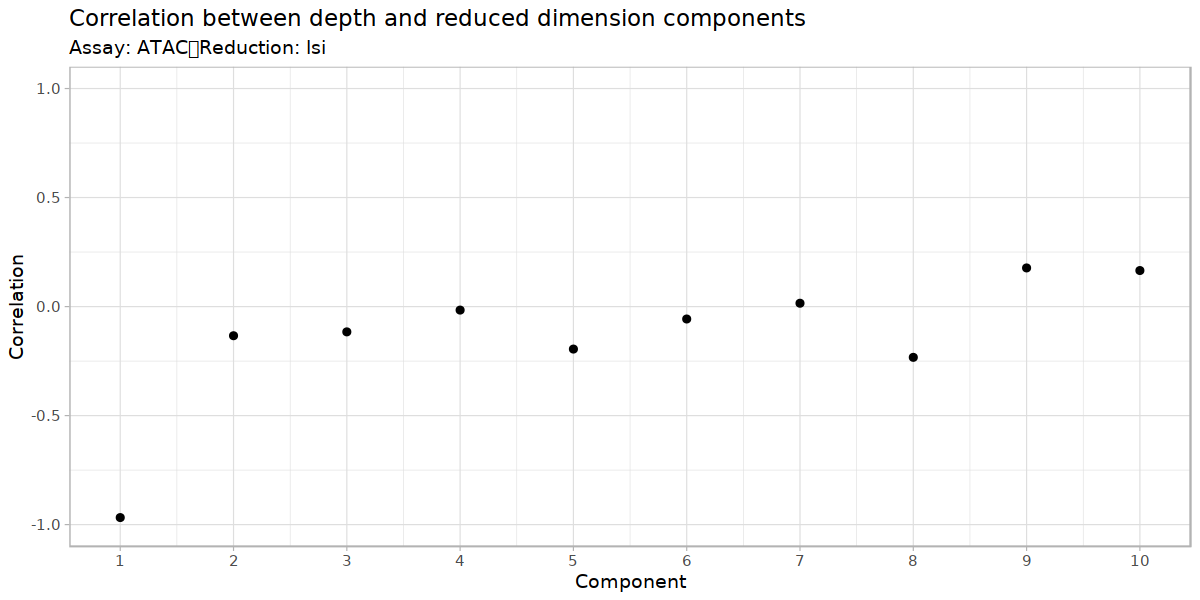

In [58]:
options(repr.plot.width=10, repr.plot.height=5)
DepthCor(filtered)
filtered

# Get ATAC-only UMAP and ATAC clusters

In [59]:
filtered <- RunUMAP(
  object = filtered,
  reduction = 'lsi',
  dims = 2:30
)

filtered

18:08:12 UMAP embedding parameters a = 0.9922 b = 1.112

18:08:12 Read 390 rows and found 29 numeric columns

18:08:12 Using Annoy for neighbor search, n_neighbors = 30

18:08:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:08:12 Writing NN index file to temp file /tmp/RtmpC0D4EP/file895a4a664e07

18:08:12 Searching Annoy index using 1 thread, search_k = 3000

18:08:12 Annoy recall = 100%

18:08:13 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:08:15 Initializing from normalized Laplacian + noise (using irlba)

18:08:15 Commencing optimization for 500 epochs, with 14206 positive edges

18:08:17 Optimization finished



An object of class Seurat 
213025 features across 390 samples within 1 assay 
Active assay: ATAC (213025 features, 209706 variable features)
 2 dimensional reductions calculated: lsi, umap

In [60]:
filtered <- FindNeighbors(
  object = filtered,
  reduction = 'lsi',
  dims = 2:30
)

filtered

Computing nearest neighbor graph

Computing SNN



An object of class Seurat 
213025 features across 390 samples within 1 assay 
Active assay: ATAC (213025 features, 209706 variable features)
 2 dimensional reductions calculated: lsi, umap

In [61]:
filtered <- FindClusters(
  object = filtered,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

filtered

An object of class Seurat 
213025 features across 390 samples within 1 assay 
Active assay: ATAC (213025 features, 209706 variable features)
 2 dimensional reductions calculated: lsi, umap

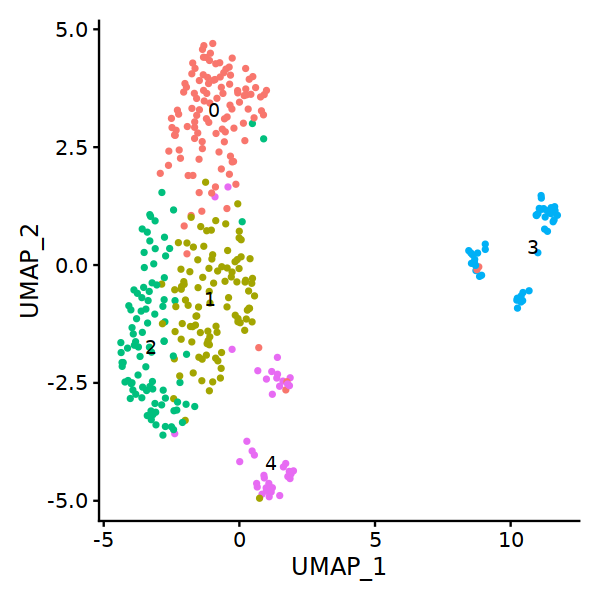

In [62]:
options(repr.plot.width=5, repr.plot.height=5)

DimPlot(object = filtered, label = TRUE) + NoLegend()

# Anchor to published RNA data
P4 scRNA-seq from https://www.nature.com/articles/s41586-021-03670-5

## Load data

In [63]:
rna_counts_all_path = '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/dibella_habibi_data/SCP1290/expression/601ae2f4771a5b0d72588bfb'
rna_counts_all_path

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/dibella_habibi_data/SCP1290/expression/601ae2f4771a5b0d72588bfb"

In [64]:
rna_counts_all <- Read10X(rna_counts_all_path)

In [65]:
head(colnames(rna_counts_all))
dim(rna_counts_all)

[1] "E10_v1_AAACCTGAGGGTCTCC-1" "E10_v1_AAACCTGCACAACGCC-1"
[3] "E10_v1_AAACCTGCACGACGAA-1" "E10_v1_AAACCTGCAGACAAGC-1"
[5] "E10_v1_AAACCTGCAGAGCCAA-1" "E10_v1_AAACCTGGTGGCCCTA-1"

[1] 19712 98047

In [66]:
table(str_split_i(colnames(rna_counts_all), '_', 1))


  E10   E11   E12   E13   E14   E15   E16   E17   E18    P1    P4 
 2989  4221  9348  8907  5249 11670  5761  9381 20275 13072  7174 

## Create scRNA object

### Load metadata

In [67]:
rna_meta_path = '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/dibella_habibi_data/SCP1290/metadata/metaData_scDevSC.txt'

rna_meta <- read.csv(
  file = rna_meta_path,
  header = TRUE,
  row.names = 1,
  sep='\t'
)

# http://www.sthda.com/english/wiki/reading-data-from-txt-csv-files-r-base-functions

In [68]:
rna_meta = rna_meta[-1,]
# https://stackoverflow.com/questions/7541610/how-to-delete-the-first-row-of-a-dataframe-in-r

In [69]:
head(rna_meta)
dim(rna_meta)

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,RNA_snn_res_1,scrublet_doublet,RNA_snn_res_2,Doublet_intersect,Gral_cellType,New_cellType,biosample_id,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
E10_v1_AAACCTGAGGGTCTCC-1,E10,1544,1022,0.02007772,51,0.356987282,0.330795055,S,0.026192226,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACAACGCC-1,E10,1157,783,0.014693172,39,0.453853807,0.260559945,S,0.193293862,34,20,FALSE,34,NA,NA,Intermediate progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACGACGAA-1,E10,2081,1200,0.016338299,67,0.447598221,0.218745871,S,0.228852351,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGACAAGC-1,E10,2490,1430,0.021285141,71,0.227723147,0.307101877,G2M,-0.079378731,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGAGCCAA-1,E10,2514,1416,0.021081941,70,0.738406445,0.136556035,S,0.601850411,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGGTGGCCCTA-1,E10,1009,692,0.026759167,50,0.565625946,0.094001224,S,0.471624722,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


[1] 98047    27

In [70]:
colnames(rna_meta)

[1] "orig_ident"                                  
 [2] "nCount_RNA"                                  
 [3] "nFeature_RNA"                                
 [4] "percent_mito"                                
 [5] "n_hkgene"                                    
 [6] "S_Score"                                     
 [7] "G2M_Score"                                   
 [8] "Phase"                                       
 [9] "CC_Difference"                               
[10] "seurat_clusters"                             
[11] "RNA_snn_res_1"                               
[12] "scrublet_doublet"                            
[13] "RNA_snn_res_2"                               
[14] "Doublet_intersect"                           
[15] "Gral_cellType"                               
[16] "New_cellType"                                
[17] "biosample_id"                                
[18] "donor_id"                                    
[19] "species"                                     
[20] "disease"                                     
[21] "disease__ontology_label"                     
[22] "organ"                                       
[23] "organ__ontology_label"                       
[24] "library_preparation_protocol"                
[25] "library_preparation_protocol__ontology_label"
[26] "sex"                                         
[27] "species__ontology_label"

In [71]:
# cutoffs set in the paper
# section "scRNA-seq pre-processing, initial analysis and clustering"

max(rna_meta$percent_mito)
min(rna_meta$nCount_RNA)

[1] "0.074982481"

[1] "1000"

In [72]:
table(rna_meta$Doublet_intersect)


Doublet Singlet 
   1877   76626 

In [73]:
head(rna_meta)
dim(rna_meta)

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,RNA_snn_res_1,scrublet_doublet,RNA_snn_res_2,Doublet_intersect,Gral_cellType,New_cellType,biosample_id,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
E10_v1_AAACCTGAGGGTCTCC-1,E10,1544,1022,0.02007772,51,0.356987282,0.330795055,S,0.026192226,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACAACGCC-1,E10,1157,783,0.014693172,39,0.453853807,0.260559945,S,0.193293862,34,20,FALSE,34,NA,NA,Intermediate progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACGACGAA-1,E10,2081,1200,0.016338299,67,0.447598221,0.218745871,S,0.228852351,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGACAAGC-1,E10,2490,1430,0.021285141,71,0.227723147,0.307101877,G2M,-0.079378731,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGAGCCAA-1,E10,2514,1416,0.021081941,70,0.738406445,0.136556035,S,0.601850411,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGGTGGCCCTA-1,E10,1009,692,0.026759167,50,0.565625946,0.094001224,S,0.471624722,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


[1] 98047    27

In [74]:
# sanity check P4 cells
rna_meta_p4 = rna_meta[rna_meta$orig_ident == 'P4', ]

head(rna_meta_p4)
dim(rna_meta_p4)

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,RNA_snn_res_1,scrublet_doublet,RNA_snn_res_2,Doublet_intersect,Gral_cellType,New_cellType,biosample_id,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P4_AAACCTGAGATCGATA-1,P4,6111,2626,0.0445099,75,-0.146672048,-0.215651807,G1,0.068979759,16,18,FALSE,16,NA,NA,Layer 4,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGCTAACAA-1,P4,3431,1615,0.029437482,68,-0.067566842,-0.206909349,G1,0.139342506,53,36,FALSE,53,NA,NA,Endothelial cells,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGGCCCTTG-1,P4,2363,1395,0.028353788,60,-0.137610546,-0.14879381,G1,0.011183263,45,21,FALSE,45,NA,NA,Astrocytes,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGTCCGGTC-1,P4,2670,1421,0.049812734,71,-0.087189708,-0.20126696,G1,0.114077252,19,0,FALSE,19,NA,NA,Immature neurons,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGTGTACTC-1,P4,4997,2084,0.031618971,71,-0.162679699,-0.164959164,G1,0.002279465,33,27,FALSE,33,NA,NA,Astrocytes,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGCAAGCGTAG-1,P4,6576,2712,0.059154501,73,-0.15827966,-0.223414137,G1,0.065134477,16,18,FALSE,16,NA,NA,UL CPN,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


[1] 7174   27

In [75]:
# sanity check that all P4 matrix cell barcodes are identical to the metadata P4 cell barcodes
p4_meta_bc <- rownames(rna_meta_p4)
p4_mat_bc <- colnames(rna_counts_all)[grep("^P4", colnames(rna_counts_all))]

setequal(p4_meta_bc, p4_mat_bc)

# https://chat.openai.com/share/2dc78c27-f288-426a-9f51-9dc67b924457
# https://stackoverflow.com/questions/37656853/how-to-check-if-set-a-is-subset-of-set-b-in-r

[1] TRUE

### Create object

In [76]:
# create a Seurat object containing the RNA data (after CellBender)
rna_obj <- CreateSeuratObject(
    counts = rna_counts_all,   # CellBender-corrected, RNA-only
    assay = "RNA",
    meta.data = rna_meta
)

In [77]:
rna_obj

An object of class Seurat 
19712 features across 98047 samples within 1 assay 
Active assay: RNA (19712 features, 0 variable features)

### Subset the object for P4

In [78]:
rna_obj_p4 <- subset(x = rna_obj, orig_ident == 'P4')

rna_obj_p4

An object of class Seurat 
19712 features across 7174 samples within 1 assay 
Active assay: RNA (19712 features, 0 variable features)

### Filter out annotated low quality cells

In [79]:
# filter out low quality cells
rna_obj_p4 <- subset(
  x = rna_obj_p4,
  subset = scrublet_doublet == FALSE &
    New_cellType != "Low quality cells"
)

rna_obj_p4

An object of class Seurat 
19712 features across 6804 samples within 1 assay 
Active assay: RNA (19712 features, 0 variable features)

## Preprocess scRNA data

In [80]:
DefaultAssay(rna_obj_p4) <- "RNA"
rna_obj_p4 <- SCTransform(rna_obj_p4)
rna_obj_p4 <- RunPCA(rna_obj_p4)

rna_obj_p4

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15824 by 6804

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 203 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15824 genes



  |======================================================================| 100%


Computing corrected count matrix for 15824 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.575228 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  Cck, Npy, Igfbpl1, Ostn, Rpp25, Islr2, Gad1, Bcl11b, Lhx6, Synpr 
	   Rorb, Slc32a1, Spock3, Thsd7a, Dlx2, Kcnc1, Mafb, Sst, Dlx5, Nxph2 
	   Dlx1, Rgs10, Reln, Calb1, Nrxn3, Grip1, Maf, Calb2, Pnoc, Sema3c 
Negative:  Apoe, Fabp7, Aldoc, Hes5, Id3, Mfge8, Slc1a3, Mt3, Cd9, Mt1 
	   Phgdh, Mlc1, Bcan, Atp1a2, Plpp3, Sparc, Pla2g7, Ndrg2, Acot1, Dbi 
	   Acsbg1, S100a16, Cyr61, Pon2, Id1, Sparcl1, Ccnd2, Tst, Lxn, Slc9a3r1 
PC_ 2 
Positive:  Aldoc, Fabp7, Hes5, Mt3, Slc1a3, Mlc1, Bcan, Pla2g7, Plpp3, Acsbg1 
	   Ndrg2, Tst, Acot1, Aldh1l1, Ptprz1, Mmd2, Cldn10, Tspan7, Gfap, Aqp4 
	   Phgdh, Slc1a2, Vcam1, Cbs, Dbi, Mt2, Mfge8, Ttyh1, Ccdc80, Clu 
Negative:  Sepp1, Ecscr, Igfbp7, Trf, Anxa3, Ctsh, Gng11, Vamp8, Tgfb1, C1qb 
	   Fcer1g, C1qc, Tyrobp, Bgn, C1qa, Fcgrt, 

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: SCT (15824 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: SCT (15824 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

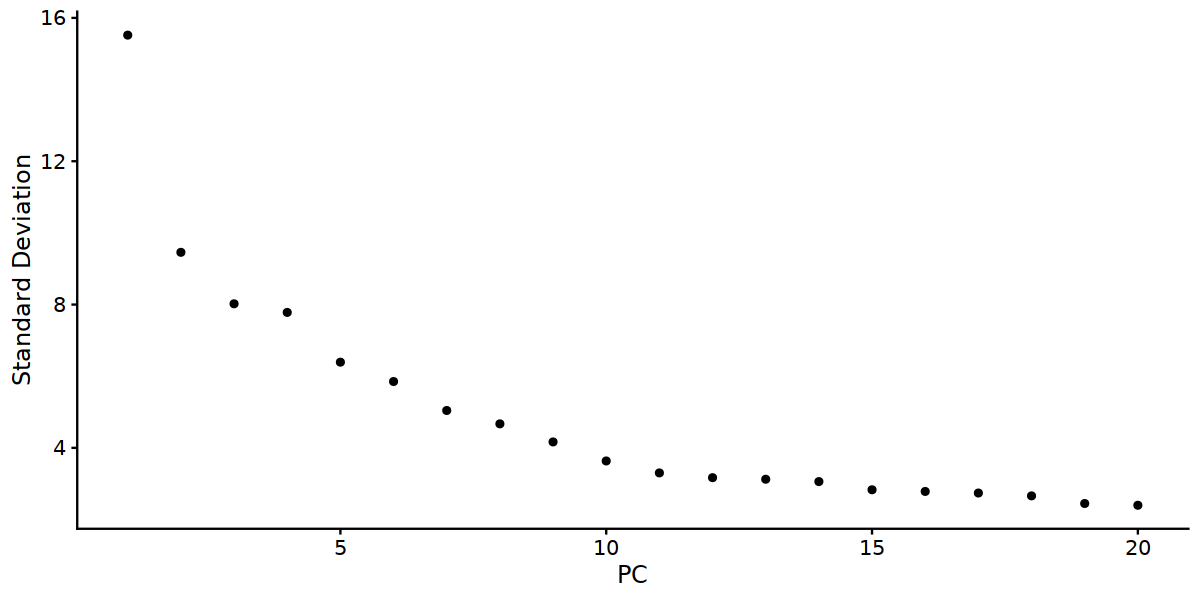

In [81]:
options(repr.plot.width=10, repr.plot.height=5)
ElbowPlot(rna_obj_p4)
rna_obj_p4

## Get RNA neighbor graph

In [82]:
# build a neighbor graph using SCT assay
DefaultAssay(rna_obj_p4) <- 'SCT'
rna_obj_p4 <- FindNeighbors(object = rna_obj_p4,
                                  reduction = 'pca',
                                  dims = 1:50,
                                  verbose = TRUE
                                  )

Computing nearest neighbor graph

Computing SNN



In [83]:
Graphs(rna_obj_p4)

[1] "SCT_nn"  "SCT_snn"

## Get RNA UMAP

In [84]:
rna_obj_p4 <- RunUMAP(
  object = rna_obj_p4,
  reduction = "pca", 
  dims = 1:50,
  reduction.name = "rna_only_UMAP",
  reduction.key = "rna_only_UMAP_",
  verbose = TRUE
)
     
# https://satijalab.org/seurat/articles/integration_introduction.html
# https://satijalab.org/seurat/reference/runumap


18:11:58 UMAP embedding parameters a = 0.9922 b = 1.112

18:11:58 Read 6804 rows and found 50 numeric columns

18:11:58 Using Annoy for neighbor search, n_neighbors = 30

18:11:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:11:59 Writing NN index file to temp file /tmp/RtmpC0D4EP/file895abf27e11

18:11:59 Searching Annoy index using 1 thread, search_k = 3000

18:12:01 Annoy recall = 100%

18:12:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:12:04 Initializing from normalized Laplacian + noise (using irlba)

18:12:05 Commencing optimization for 500 epochs, with 332522 positive edges

18:12:27 Optimization finished



## Clustering

In [85]:
rna_obj_p4 <- FindClusters(
  object = rna_obj_p4,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

rna_obj_p4

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: SCT (15824 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, rna_only_UMAP

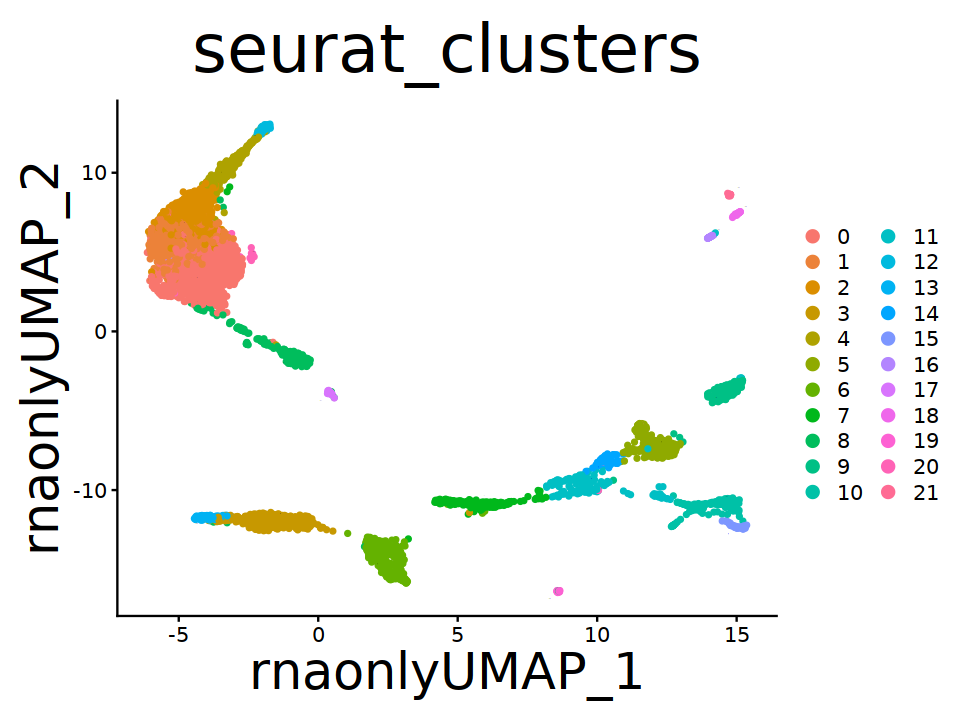

In [86]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna_obj_p4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'seurat_clusters', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

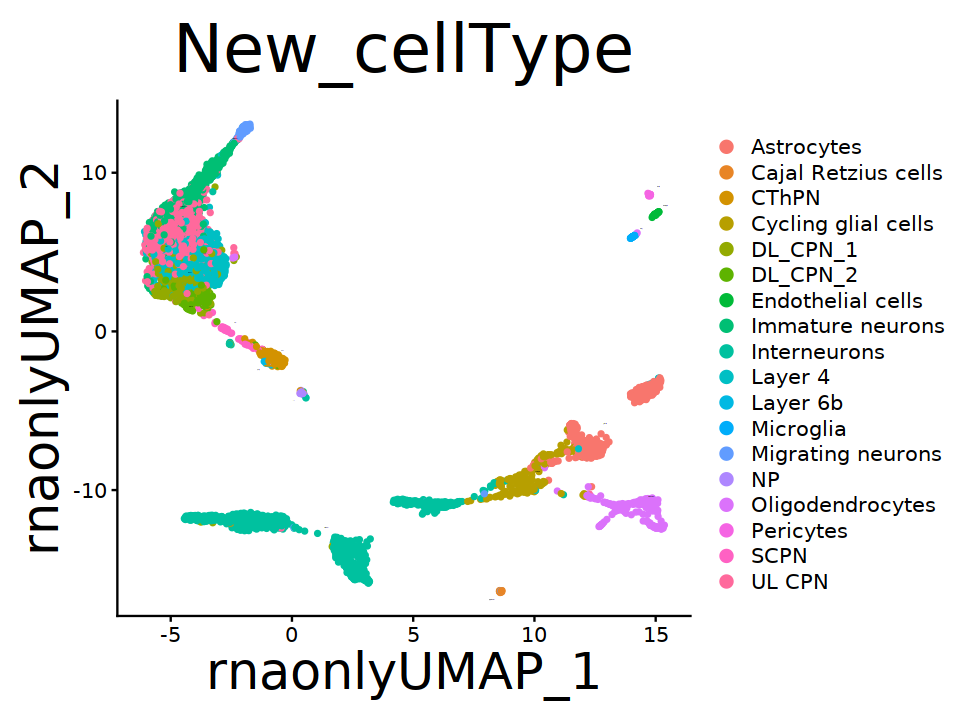

In [87]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna_obj_p4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'New_cellType', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

# Get ATAC gene activities

In [88]:
# compute gene activities
gene.activities <- GeneActivity(filtered)

# add the gene activity matrix to the Seurat object as a new assay
filtered[['RNA']] <- CreateAssayObject(counts = gene.activities)
filtered <- NormalizeData(
  object = filtered,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(filtered$nCount_RNA)
)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [89]:
filtered

An object of class Seurat 
234833 features across 390 samples within 2 assays 
Active assay: ATAC (213025 features, 209706 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# Transfer labels to ATAC

In [90]:
DefaultAssay(rna_obj_p4) <- 'RNA'
rna_obj_p4 <- FindVariableFeatures(
  object = rna_obj_p4,
  nfeatures = 5000
)

rna_obj_p4

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: RNA (19712 features, 5000 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, rna_only_UMAP

In [91]:
DefaultAssay(rna_obj_p4) <- 'RNA'

transfer.anchors <- FindTransferAnchors(
  reference = rna_obj_p4,
  query.assay = 'RNA',
  query = filtered,
  reduction = 'cca',
  dims = 1:50
)


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1950 anchors

Filtering anchors

	Retained 1278 anchors



In [92]:
predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = rna_obj_p4$New_cellType,
  weight.reduction = filtered[['lsi']],
  dims = 2:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [93]:
# add predicted labels to ATAC metadata

filtered <- AddMetaData(object = filtered, metadata = predicted.labels)

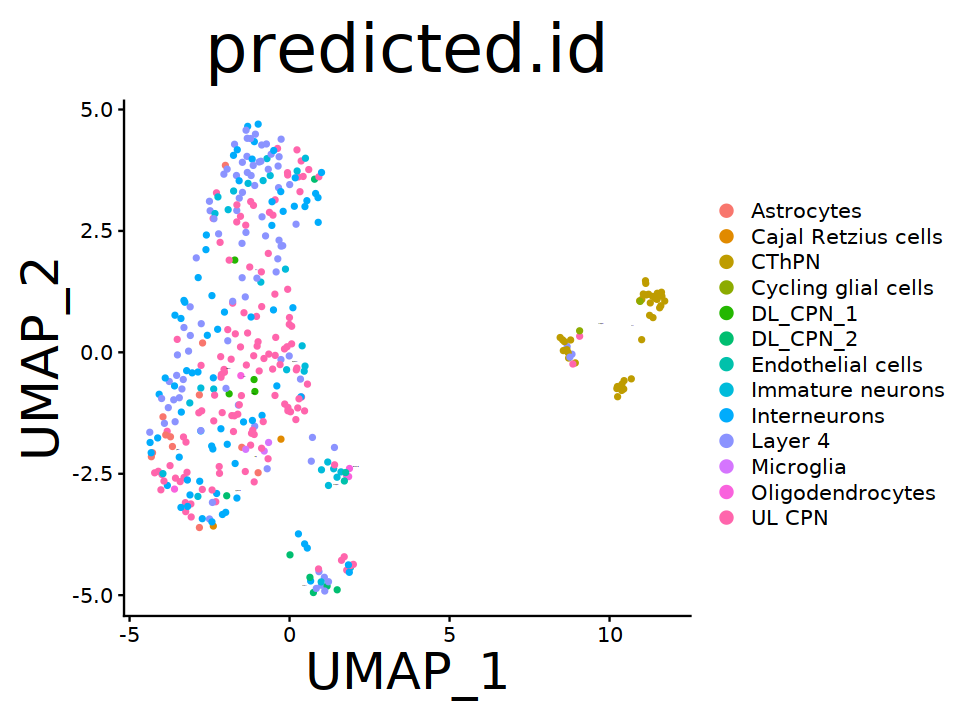

In [94]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(filtered, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, group.by = 'predicted.id', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

In [95]:
table(filtered$predicted.id)


         Astrocytes Cajal Retzius cells               CThPN Cycling glial cells 
                 12                   2                  37                   2 
           DL_CPN_1            DL_CPN_2   Endothelial cells    Immature neurons 
                  4                   7                   2                  29 
       Interneurons             Layer 4           Microglia    Oligodendrocytes 
                 75                  87                   3                   5 
             UL CPN 
                125 

# Save filtered, development-annotated ATAC object

### Change predicted.id column name (since doing Azimuth afterwards)

In [96]:
# sanity check
setequal(colnames(filtered@meta.data), names(filtered@meta.data))

[1] TRUE

In [97]:
colnames(filtered@meta.data)

[1] "orig.ident"                          
 [2] "nCount_ATAC"                         
 [3] "nFeature_ATAC"                       
 [4] "total"                               
 [5] "duplicate"                           
 [6] "chimeric"                            
 [7] "unmapped"                            
 [8] "lowmapq"                             
 [9] "mitochondrial"                       
[10] "nonprimary"                          
[11] "passed_filters"                      
[12] "is__cell_barcode"                    
[13] "excluded_reason"                     
[14] "TSS_fragments"                       
[15] "DNase_sensitive_region_fragments"    
[16] "enhancer_region_fragments"           
[17] "promoter_region_fragments"           
[18] "on_target_fragments"                 
[19] "blacklist_region_fragments"          
[20] "peak_region_fragments"               
[21] "peak_region_cutsites"                
[22] "nucleosome_signal"                   
[23] "nucleosome_percentile"               
[24] "TSS.enrichment"                      
[25] "TSS.percentile"                      
[26] "pct_frags_in_peaks"                  
[27] "blacklist_ratio"                     
[28] "ATAC_snn_res.1.2"                    
[29] "seurat_clusters"                     
[30] "nCount_RNA"                          
[31] "nFeature_RNA"                        
[32] "predicted.id"                        
[33] "prediction.score.Layer.4"            
[34] "prediction.score.Endothelial.cells"  
[35] "prediction.score.Astrocytes"         
[36] "prediction.score.Immature.neurons"   
[37] "prediction.score.UL.CPN"             
[38] "prediction.score.Interneurons"       
[39] "prediction.score.CThPN"              
[40] "prediction.score.DL_CPN_1"           
[41] "prediction.score.NP"                 
[42] "prediction.score.Oligodendrocytes"   
[43] "prediction.score.Cycling.glial.cells"
[44] "prediction.score.DL_CPN_2"           
[45] "prediction.score.SCPN"               
[46] "prediction.score.Migrating.neurons"  
[47] "prediction.score.Pericytes"          
[48] "prediction.score.Microglia"          
[49] "prediction.score.Cajal.Retzius.cells"
[50] "prediction.score.Layer.6b"           
[51] "prediction.score.max"

In [98]:
# rename predicted.id
names(filtered@meta.data)[names(filtered@meta.data) == 'predicted.id'] <- 'predicted.id.dev'

# https://stackoverflow.com/questions/7531868/how-to-rename-a-single-column-in-a-data-frame

In [99]:
colnames(filtered@meta.data)

[1] "orig.ident"                          
 [2] "nCount_ATAC"                         
 [3] "nFeature_ATAC"                       
 [4] "total"                               
 [5] "duplicate"                           
 [6] "chimeric"                            
 [7] "unmapped"                            
 [8] "lowmapq"                             
 [9] "mitochondrial"                       
[10] "nonprimary"                          
[11] "passed_filters"                      
[12] "is__cell_barcode"                    
[13] "excluded_reason"                     
[14] "TSS_fragments"                       
[15] "DNase_sensitive_region_fragments"    
[16] "enhancer_region_fragments"           
[17] "promoter_region_fragments"           
[18] "on_target_fragments"                 
[19] "blacklist_region_fragments"          
[20] "peak_region_fragments"               
[21] "peak_region_cutsites"                
[22] "nucleosome_signal"                   
[23] "nucleosome_percentile"               
[24] "TSS.enrichment"                      
[25] "TSS.percentile"                      
[26] "pct_frags_in_peaks"                  
[27] "blacklist_ratio"                     
[28] "ATAC_snn_res.1.2"                    
[29] "seurat_clusters"                     
[30] "nCount_RNA"                          
[31] "nFeature_RNA"                        
[32] "predicted.id.dev"                    
[33] "prediction.score.Layer.4"            
[34] "prediction.score.Endothelial.cells"  
[35] "prediction.score.Astrocytes"         
[36] "prediction.score.Immature.neurons"   
[37] "prediction.score.UL.CPN"             
[38] "prediction.score.Interneurons"       
[39] "prediction.score.CThPN"              
[40] "prediction.score.DL_CPN_1"           
[41] "prediction.score.NP"                 
[42] "prediction.score.Oligodendrocytes"   
[43] "prediction.score.Cycling.glial.cells"
[44] "prediction.score.DL_CPN_2"           
[45] "prediction.score.SCPN"               
[46] "prediction.score.Migrating.neurons"  
[47] "prediction.score.Pericytes"          
[48] "prediction.score.Microglia"          
[49] "prediction.score.Cajal.Retzius.cells"
[50] "prediction.score.Layer.6b"           
[51] "prediction.score.max"

### Save the object

In [100]:
save_path_filt_annot <- paste0(outdir, "/filtered_objects/", sample, ".filtered.dev.annotated.rds")

saveRDS(filtered, file = save_path_filt_annot)

In [101]:
print(save_path_filt_annot)

filtered

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects/V1.filtered.dev.annotated.rds"


An object of class Seurat 
234833 features across 390 samples within 2 assays 
Active assay: ATAC (213025 features, 209706 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# Anchor to Azimuth

In [102]:
filtered

An object of class Seurat 
234833 features across 390 samples within 2 assays 
Active assay: ATAC (213025 features, 209706 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

### Load Allen Mouse Motor Cortex scRNA-seq rds object

In [103]:
mouse_motor_cortex_ref_path = '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/allen_mousecortexref_data/allen_mop_2020.rds'
mouse_motor_cortex_ref_path

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/allen_mousecortexref_data/allen_mop_2020.rds"

In [104]:
allen_motor_cortex_rna_rds <- readRDS(file = mouse_motor_cortex_ref_path)

allen_motor_cortex_rna_rds

An object of class Seurat 
31053 features across 5666 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)

In [105]:
allen_motor_cortex_rna_rds@meta.data

,class,cluster,subclass,donor_sex,region,cortical_layer,external_donor_name,nCount_RNA,nFeature_RNA
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>
GACCTGGAGGAATGGA-L8TX_171026_01_F03,GABAergic,9_Lamp5,Lamp5,M,MOp,All,352353,14759,5238
GCAATCAAGTAATCCC-L8TX_171026_01_A05,GABAergic,9_Lamp5,Lamp5,M,MOp,All,352356,15335,5194
TCTTTCCTCATGTCCC-L8TX_171026_01_G05,GABAergic,9_Lamp5,Lamp5,M,MOp,All,352357,7463,3441
GCGAGAACACTCAGGC-L8TX_171026_01_F03,GABAergic,3_Lamp5 Lhx6,Lamp5,M,MOp,All,352353,8062,3511
TACACGATCCAGAAGG-L8TX_171026_01_D05,GABAergic,12_Lamp5,Lamp5,M,MOp,All,352357,7709,3448
CGCCAAGCAGAGCCAA-L8TX_171026_01_B05,GABAergic,25_Sncg,Sncg,M,MOp,All,352356,21139,5902
CGGACGTGTTGCTCCT-L8TX_171026_01_H04,GABAergic,25_Sncg,Sncg,M,MOp,All,352356,14388,4913
TACTCATCACTACAGT-L8TX_171026_01_G04,GABAergic,26_Sncg,Sncg,M,MOp,All,352356,25758,6260
GATCGATGTGACAAAT-L8TX_171026_01_B04,GABAergic,30_Sncg,Sncg,M,MOp,All,352353,32169,7030


In [106]:
table(allen_motor_cortex_rna_rds@meta.data$class)
table(allen_motor_cortex_rna_rds@meta.data$subclass)


    GABAergic Glutamatergic  Non-Neuronal 
         1800          3016           850 


        Astro          Car3            CR          Endo     L2 IT RHP 
          300           300            10           104             1 
L2/3 IT CTX-1 L2/3 IT CTX-2   L2/3 IT PPP    L3 RSP-ACA   L4/5 IT CTX 
          300           300             1             1           300 
    L5 IT CTX L5 IT TPE-ENT     L5 NP CTX     L5 PT CTX     L6 CT CTX 
          300             3           300           300           300 
    L6 IT CTX       L6b CTX         Lamp5     Micro-PVM         Oligo 
          300           300           300           111           300 
        Pvalb      SMC-Peri          Sncg           Sst     Sst Chodl 
          300            27           300           300           300 
          Vip          VLMC 
          300             8 

### Preprocess scRNA data

In [107]:
DefaultAssay(allen_motor_cortex_rna_rds) <- "RNA"
allen_motor_cortex_rna_rds <- SCTransform(allen_motor_cortex_rna_rds)
allen_motor_cortex_rna_rds <- RunPCA(allen_motor_cortex_rna_rds)

allen_motor_cortex_rna_rds

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21030 by 5666

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 119 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21030 genes



  |======================================================================| 100%


Computing corrected count matrix for 21030 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.590927 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  Meg3, Nrgn, Pcp4, Gm28928, Kcnip4, Lrrtm4, Camk2n1, Nrxn3, Galntl6, Rbfox1 
	   Cntnap2, Nrg3, Mgat4c, Hs3st4, Cdh18, Cck, Kcnq5, Mef2c, Pde1a, Lingo2 
	   Csmd1, Frmpd4, Ptprd, Gad1, Tenm2, Gad2, Fam19a1, Arpp21, Etl4, Grik1 
Negative:  Qk, Atp1a2, Slc1a3, Glul, Plpp3, Gpc5, Mt1, Apoe, Cst3, Ptprz1 
	   Mertk, S1pr1, Hepacam, Gja1, St3gal4, Prex2, Csrp1, Selenop, Luzp2, Slco1c1 
	   Maml2, Gpr37l1, Zbtb20, Tsc22d4, Lsamp, Mt2, Slc1a2, Mfge8, S100a16, Cdh19 
PC_ 2 
Positive:  Nrgn, Gm28928, Slc17a7, Camk2n1, Hs3st4, Ptprd, Fam19a1, Arpp21, 3110035E14Rik, C1ql3 
	   Nrn1, Sv2b, Slc1a2, Rasgrp1, Lmo4, Rgs4, Pcp4, Car10, Nptx1, Lingo1 
	   Ano3, Enc1, Prkcb, Satb2, Atp2b1, 1110008P14Rik, Baiap2, Celf2, Homer1, Egr1 
Negative:  Erbb4, Gad1, Gad2, Adarb2, Galntl6, Npas3, 

An object of class Seurat 
52083 features across 5666 samples within 2 assays 
Active assay: SCT (21030 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

An object of class Seurat 
52083 features across 5666 samples within 2 assays 
Active assay: SCT (21030 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

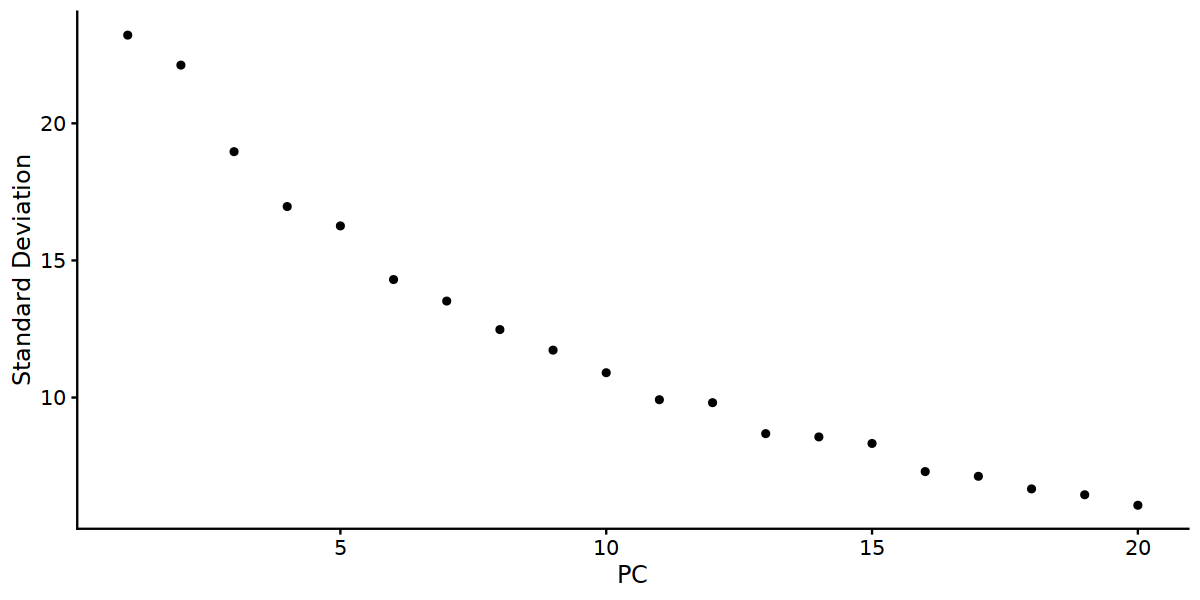

In [108]:
options(repr.plot.width=10, repr.plot.height=5)
ElbowPlot(allen_motor_cortex_rna_rds)
allen_motor_cortex_rna_rds

### Get RNA neighbor graph

In [109]:
# build a neighbor graph using SCT assay
DefaultAssay(allen_motor_cortex_rna_rds) <- 'SCT'
allen_motor_cortex_rna_rds <- FindNeighbors(object = allen_motor_cortex_rna_rds,
                                  reduction = 'pca',
                                  dims = 1:50,
                                  verbose = TRUE
                                  )

Computing nearest neighbor graph

Computing SNN



In [110]:
Graphs(allen_motor_cortex_rna_rds)

[1] "SCT_nn"  "SCT_snn"

### Get RNA UMAP

In [111]:
allen_motor_cortex_rna_rds <- RunUMAP(
  object = allen_motor_cortex_rna_rds,
  reduction = "pca", 
  dims = 1:50,
  reduction.name = "rna_only_UMAP",
  reduction.key = "rna_only_UMAP_",
  verbose = TRUE
)
     
# https://satijalab.org/seurat/articles/integration_introduction.html
# https://satijalab.org/seurat/reference/runumap


18:15:41 UMAP embedding parameters a = 0.9922 b = 1.112

18:15:41 Read 5666 rows and found 50 numeric columns

18:15:41 Using Annoy for neighbor search, n_neighbors = 30

18:15:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:15:42 Writing NN index file to temp file /tmp/RtmpC0D4EP/file895a134802aa

18:15:42 Searching Annoy index using 1 thread, search_k = 3000

18:15:43 Annoy recall = 100%

18:15:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:15:46 Found 4 connected components, 
falling back to 'spca' initialization with init_sdev = 1

18:15:46 Using 'irlba' for PCA

18:15:46 PCA: 2 components explained 26.43% variance

18:15:46 Scaling init to sdev = 1

18:15:46 Commencing optimization for 500 epochs, with 216828 p

## Clustering

In [112]:
allen_motor_cortex_rna_rds <- FindClusters(
  object = allen_motor_cortex_rna_rds,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

rna_obj_p4

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: RNA (19712 features, 5000 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, rna_only_UMAP

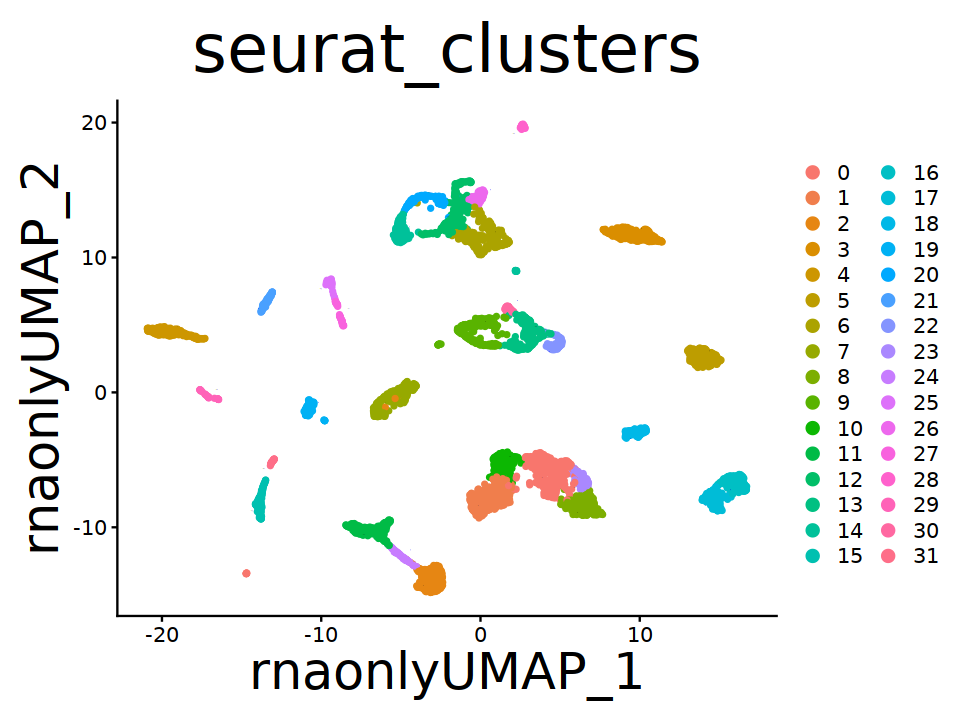

In [113]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(allen_motor_cortex_rna_rds, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'seurat_clusters', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

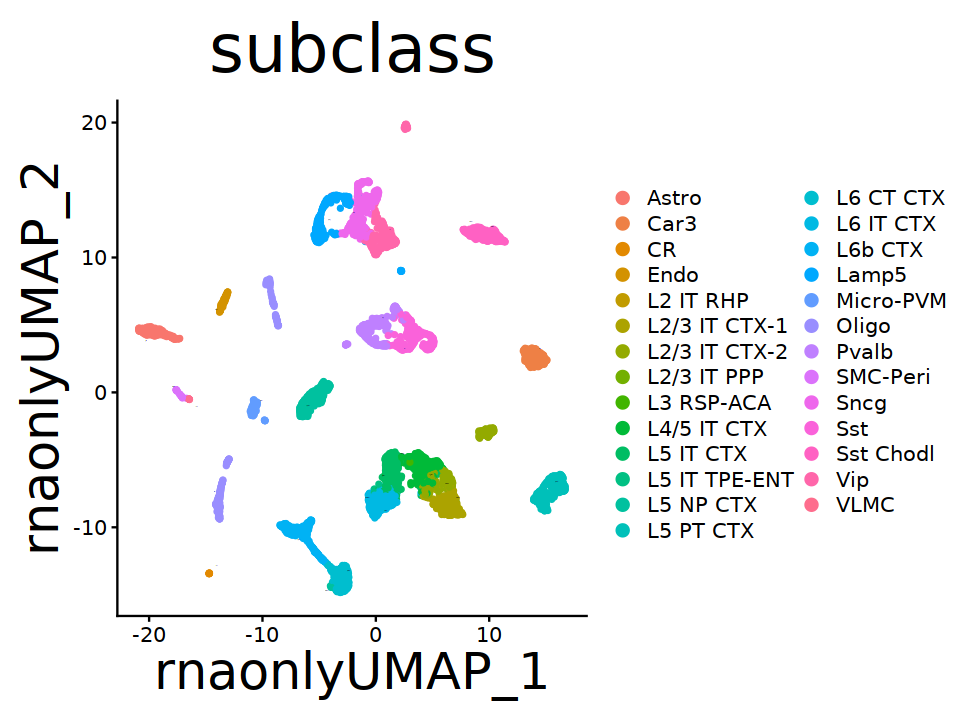

In [114]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(allen_motor_cortex_rna_rds, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'subclass', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

# Transfer labels to ATAC

In [115]:
DefaultAssay(allen_motor_cortex_rna_rds) <- 'RNA'
allen_motor_cortex_rna_rds <- FindVariableFeatures(
  object = allen_motor_cortex_rna_rds,
  nfeatures = 5000
)

allen_motor_cortex_rna_rds

An object of class Seurat 
52083 features across 5666 samples within 2 assays 
Active assay: RNA (31053 features, 5000 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, rna_only_UMAP

In [116]:
DefaultAssay(allen_motor_cortex_rna_rds) <- 'RNA'

transfer.anchors.motor.cortex <- FindTransferAnchors(
  reference = allen_motor_cortex_rna_rds,
  query.assay = 'RNA',
  query = filtered,
  reduction = 'cca',
  dims = 1:50
)


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1948 anchors

Filtering anchors

	Retained 1372 anchors



In [117]:
predicted.labels.motor.cortex <- TransferData(
  anchorset = transfer.anchors.motor.cortex,
  refdata = allen_motor_cortex_rna_rds$subclass,
  weight.reduction = filtered[['lsi']],
  dims = 2:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [118]:
# add predicted labels to ATAC metadata

filtered <- AddMetaData(object = filtered, metadata = predicted.labels.motor.cortex)

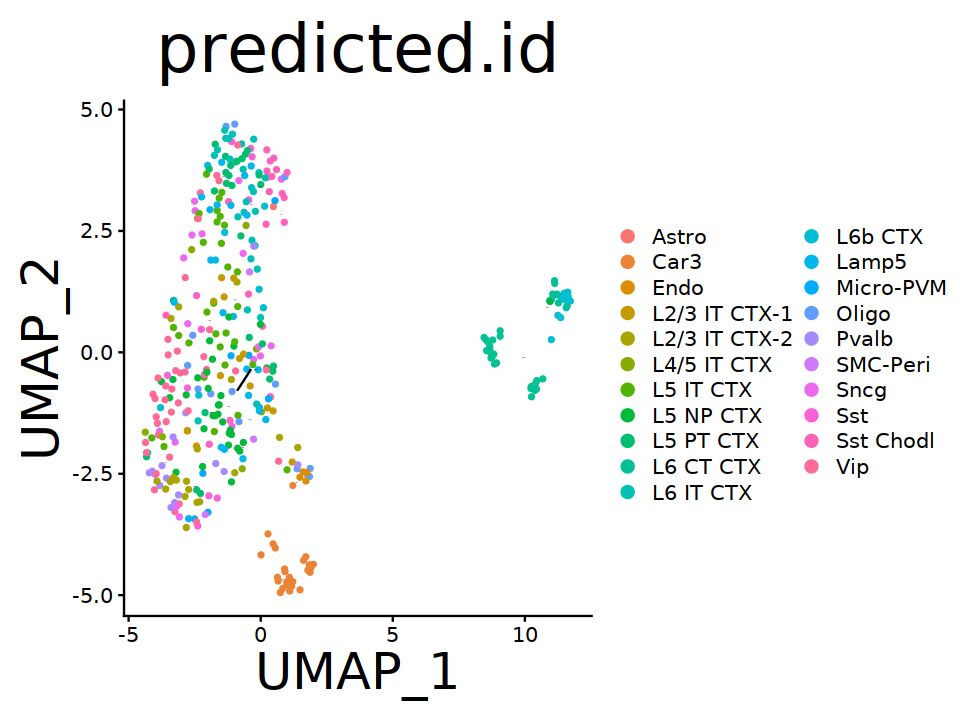

In [119]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(filtered, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, group.by = 'predicted.id', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

In [120]:
table(filtered$predicted.id)


        Astro          Car3          Endo L2/3 IT CTX-1 L2/3 IT CTX-2 
            1            26             4            14            20 
  L4/5 IT CTX     L5 IT CTX     L5 NP CTX     L5 PT CTX     L6 CT CTX 
            7            31            32            26            31 
    L6 IT CTX       L6b CTX         Lamp5     Micro-PVM         Oligo 
           26            20            24             7            14 
        Pvalb      SMC-Peri          Sncg           Sst     Sst Chodl 
           15             3            18            12            20 
          Vip 
           39 

In [121]:
colnames(filtered@meta.data)

[1] "orig.ident"                          
 [2] "nCount_ATAC"                         
 [3] "nFeature_ATAC"                       
 [4] "total"                               
 [5] "duplicate"                           
 [6] "chimeric"                            
 [7] "unmapped"                            
 [8] "lowmapq"                             
 [9] "mitochondrial"                       
[10] "nonprimary"                          
[11] "passed_filters"                      
[12] "is__cell_barcode"                    
[13] "excluded_reason"                     
[14] "TSS_fragments"                       
[15] "DNase_sensitive_region_fragments"    
[16] "enhancer_region_fragments"           
[17] "promoter_region_fragments"           
[18] "on_target_fragments"                 
[19] "blacklist_region_fragments"          
[20] "peak_region_fragments"               
[21] "peak_region_cutsites"                
[22] "nucleosome_signal"                   
[23] "nucleosome_percentile"               
[24] "TSS.enrichment"                      
[25] "TSS.percentile"                      
[26] "pct_frags_in_peaks"                  
[27] "blacklist_ratio"                     
[28] "ATAC_snn_res.1.2"                    
[29] "seurat_clusters"                     
[30] "nCount_RNA"                          
[31] "nFeature_RNA"                        
[32] "predicted.id.dev"                    
[33] "prediction.score.Layer.4"            
[34] "prediction.score.Endothelial.cells"  
[35] "prediction.score.Astrocytes"         
[36] "prediction.score.Immature.neurons"   
[37] "prediction.score.UL.CPN"             
[38] "prediction.score.Interneurons"       
[39] "prediction.score.CThPN"              
[40] "prediction.score.DL_CPN_1"           
[41] "prediction.score.NP"                 
[42] "prediction.score.Oligodendrocytes"   
[43] "prediction.score.Cycling.glial.cells"
[44] "prediction.score.DL_CPN_2"           
[45] "prediction.score.SCPN"               
[46] "prediction.score.Migrating.neurons"  
[47] "prediction.score.Pericytes"          
[48] "prediction.score.Microglia"          
[49] "prediction.score.Cajal.Retzius.cells"
[50] "prediction.score.Layer.6b"           
[51] "prediction.score.max"                
[52] "predicted.id"                        
[53] "prediction.score.Lamp5"              
[54] "prediction.score.Sncg"               
[55] "prediction.score.Vip"                
[56] "prediction.score.Sst.Chodl"          
[57] "prediction.score.L2.IT.RHP"          
[58] "prediction.score.Sst"                
[59] "prediction.score.Pvalb"              
[60] "prediction.score.L2.3.IT.CTX.2"      
[61] "prediction.score.L4.5.IT.CTX"        
[62] "prediction.score.L5.IT.CTX"          
[63] "prediction.score.L5.PT.CTX"          
[64] "prediction.score.L5.NP.CTX"          
[65] "prediction.score.L6b.CTX"            
[66] "prediction.score.Car3"               
[67] "prediction.score.CR"                 
[68] "prediction.score.Oligo"              
[69] "prediction.score.Astro"              
[70] "prediction.score.SMC.Peri"           
[71] "prediction.score.Endo"               
[72] "prediction.score.VLMC"               
[73] "prediction.score.Micro.PVM"          
[74] "prediction.score.L6.IT.CTX"          
[75] "prediction.score.L6.CT.CTX"          
[76] "prediction.score.L2.3.IT.CTX.1"      
[77] "prediction.score.L3.RSP.ACA"         
[78] "prediction.score.L5.IT.TPE.ENT"      
[79] "prediction.score.L2.3.IT.PPP"

### Old: using RunAzimuth()
I believe RunAzimuth() SCT-normalizes the ATAC gene activity matrix, which is not appropriate

In [122]:
# DefaultAssay(filtered) <- "RNA"    # ATAC gene activity
# filtered <- RunAzimuth(query = filtered, 
#                        assay = 'RNA',
#                        umap.name = 'azimuth.ref.umap',
#                        reference = "mousecortexref")
# filtered

# Save filtered, development- AND Azimuth-annotated ATAC object

In [123]:
save_path_filt_azimuth_annot <- paste0(outdir, "/filtered_objects/", sample, ".filtered.dev.azimuth.annotated.rds")

saveRDS(filtered, file = save_path_filt_azimuth_annot)

In [124]:
print(save_path_filt_azimuth_annot)

filtered

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects/V1.filtered.dev.azimuth.annotated.rds"


An object of class Seurat 
234833 features across 390 samples within 2 assays 
Active assay: ATAC (213025 features, 209706 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# END